This file contains the code for running the final analysis and calculations.

In [1]:
# install relevant packages
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import addcyclic
from mpl_toolkits.basemap import shiftgrid
from datetime import datetime
import statsmodels.api as sm
import regionmask
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.patches import Polygon
from matplotlib import colors

In [2]:
%matplotlib inline

# Trends

Calculating the global and regional trends in the yearly 99th and 50th percentile wet-bulb temperatures. 

First, calculate the yearly 99th and 50th percentile values for each grid cell, using daily maximum wet-bulb temperatures previously computed from ERA5 data and saved on the computer.

In [3]:
# function to loop over all the years and calculate the percentile values for each year for each grid cell, for an 
# input percentile_val of interest. saves the results.
def calculate_percentile_values(percentile_val):
    # will store the results as pandas dataframes
    percentile_results_pd = pd.DataFrame()
    missing_vals_pd = pd.DataFrame()

    # loop through the year numbers to calculate the percentile value for each year, 
    # adding the results for each year to a list of arrays
    yr_nums = np.linspace(1979, 2019, 41, dtype = int)
    for yr in yr_nums:
        # define the current file name, which contains the daily max TW data (from ERA5) for this year
        curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % yr
        # load the data for this year
        curr_data = nc.Dataset(curr_filename)
        time_info = curr_data.variables['time']
        times = time_info[:]
        lat_info = curr_data.variables['latitude']
        lats = lat_info[:]
        lon_info = curr_data.variables['longitude']
        lons = lon_info[:]
        TW_info = curr_data.variables['TW']
        TWs = TW_info[:]

        # calculate the value at the percentile of interest for the year at each grid box
        curr_percentile_vals = np.percentile(TWs, percentile_val, axis = 0)
    
        # also track the number of missing values at each grid box per year
        missing_flags = np.where(np.isnan(TWs), 1, 0)
        curr_missing = np.count_nonzero(missing_flags, axis = 0)

        # also convert to dataframes and add to those
        curr_percentile_vals_pd = pd.DataFrame(curr_percentile_vals, columns = lats)
        curr_percentile_vals_pd['longitude'] = lons
        curr_percentile_vals_pd = pd.melt(curr_percentile_vals_pd, id_vars = ['longitude'], var_name = 'latitude', 
                                      value_name = 'TW_percentile')
        # add a column corresponding to the year
        curr_percentile_vals_pd['year'] = yr
        percentile_results_pd = percentile_results_pd.append(curr_percentile_vals_pd)
    
        curr_missing_pd = pd.DataFrame(curr_missing, columns = lats)
        curr_missing_pd['longitude'] = lons
        curr_missing_pd = pd.melt(curr_missing_pd, id_vars = ['longitude'], var_name = 'latitude', 
                              value_name = 'num_missing')
        # add column corresponding to the year
        curr_missing_pd['year'] = yr
        missing_vals_pd = missing_vals_pd.append(curr_missing_pd)

    # add a column corresponding to year since 1979
    percentile_results_pd['year_since_1979'] = percentile_results_pd['year'] - 1979
    missing_vals_pd['year_since_1979'] = missing_vals_pd['year'] - 1979

    # store as csv
    percentile_results_pd.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_%s_percentile_yearly.csv' % 
                             percentile_val, index = False)
    missing_vals_pd.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_missing_vals_yearly.csv', index = False)

In [4]:
# run the function for the 99th and 50th percentiles
calculate_percentile_values(99)
calculate_percentile_values(50)

Create a function for fitting a linear model to each grid cell's results over time.

In [5]:
# function to get the coefficient, r squared, and p value of the coefficient of the linear model fitting 
# the TW percentile vs year for given input data. 
# input data should have at least columns corresponding to 'year_since_1979' and 'TW_percentile'
# returns [coefficient, rsquared, coefficient p value]
def get_model_results(input_data):
    model = sm.OLS(input_data['TW_percentile'], sm.add_constant(input_data['year_since_1979'])).fit()
    return [model.params[1], model.rsquared, model.pvalues[1]]

Calculate trends in the 99th percentile.

In [6]:
# load the 99th percentile results
percentile_results_pd_99 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_yearly.csv')
# group by latitude and longitude and then get the model results for trends over the years
model_vals_99 = percentile_results_pd_99.groupby(['latitude', 'longitude'], as_index = False).apply(get_model_results)

# format appropriately
model_vals_99_df = model_vals_99.to_frame()
model_vals_99_df = model_vals_99_df.reset_index()
model_vals_99_df.columns = ['latitude', 'longitude', 'coef_rsquared_pval']
# create new data frame to break up the coefficient and r squared from how they are currently present as a list
model_vals_99_df_2 = pd.DataFrame(model_vals_99_df['coef_rsquared_pval'].to_list(), 
                                  columns = ['coef', 'rsquared', 'coef_pval'])
model_vals_99_df_2['latitude'] = model_vals_99_df['latitude']
model_vals_99_df_2['longitude'] = model_vals_99_df['longitude']

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [7]:
# store as csv
model_vals_99_df_2.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_linear_trends.csv', index = False)

Calculate trends in the 50th percentile.

In [8]:
# load the 50th percentile results
percentile_results_pd_50 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_percentile_yearly.csv')
# group by latitude and longitude and then get the model results for trends over the years
model_vals_50 = percentile_results_pd_50.groupby(['latitude', 'longitude'], as_index = False).apply(get_model_results)

# format appropriately
model_vals_50_df = model_vals_50.to_frame()
model_vals_50_df = model_vals_50_df.reset_index()
model_vals_50_df.columns = ['latitude', 'longitude', 'coef_rsquared_pval']
# create new data frame to break up the coefficient and r squared from how they are currently present as a list
model_vals_50_df_2 = pd.DataFrame(model_vals_50_df['coef_rsquared_pval'].to_list(), 
                                  columns = ['coef', 'rsquared', 'coef_pval'])
model_vals_50_df_2['latitude'] = model_vals_50_df['latitude']
model_vals_50_df_2['longitude'] = model_vals_50_df['longitude']

In [9]:
# store as csv
model_vals_50_df_2.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_percentile_linear_trends.csv', index = False)

Now take the yearly 99th and 50th percentile values and spatially average them across the AR6 regions (only including land grid points), then calculate the trends in these regional-aggregated values over time.

First, create a function to do the regional averaging.

In [10]:
# define a function to calculate the AR6 regional average TW percentile value for each year, only over land points.
# input_data should be a dataframe with columns of longitude, latitude, and TW_percentile, for a single year.
# returns a data frame with the weighted averages for each AR6 region (where the weight is the cosine of the latitude
# value of the grid point) with only land points included in the averages.
def get_ar6_regional_avg_land(input_data):
    # convert to a grid
    input_data_grid = input_data.pivot(index = 'latitude', columns = 'longitude', values = 'TW_percentile')
    
    # get longitude and latitude values
    lat_vals = input_data_grid.index.values
    lon_vals = input_data_grid.columns.values
    
    # convert to numpy array, then xarray
    input_data_grid_np = input_data_grid.to_numpy()
    input_data_xar = xr.DataArray(data = input_data_grid_np, dims = ['lat', 'lon'], 
                                  coords = {'lat': lat_vals, 'lon': lon_vals})
    
    # make a mask to select just the land coordinates
    land_mask = regionmask.defined_regions.natural_earth.land_110.mask(input_data_xar)
    input_data_xar_land_mask = input_data_xar + land_mask
    
    # make the mask for ar6 regions
    mask_ar6 = regionmask.defined_regions.ar6.land.mask_3D(input_data_xar_land_mask)
    
    # calculate the means (weighted and unweighted) of just land coordinates
    # weighted - first get weights
    weight_vals = np.cos(np.deg2rad(input_data_xar_land_mask.lat))
    input_data_mean_weighted = input_data_xar_land_mask.weighted(mask_ar6 * weight_vals).mean(dim = ('lat', 'lon'))
    # unweighted
    input_data_mean = input_data_xar_land_mask.weighted(mask_ar6 * 1).mean(dim = ('lat', 'lon'))
    
    # get results as data frame
    result_vals = pd.DataFrame({'region': input_data_mean_weighted.region.values, 'mean': input_data_mean.values, 
                               'weighted_mean': input_data_mean_weighted.values})
    return result_vals

Apply the function to the 99th percentile results.

In [11]:
# apply function to get AR6 regional averages for 99th percentile
percentile_results_pd_99 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_yearly.csv')
TW_99_perc_ar6_avg_land =  percentile_results_pd_99.groupby(['year'], 
                                                             as_index = False).apply(get_ar6_regional_avg_land)
# format appropriately to have the columns that we want
TW_99_perc_ar6_avg_land_df = TW_99_perc_ar6_avg_land.reset_index(level = 0)
TW_99_perc_ar6_avg_land_df.columns = ['year_since_1979', 'region', 'mean', 'weighted_mean']
TW_99_perc_ar6_avg_land_df = TW_99_perc_ar6_avg_land_df.reset_index(drop = True)
# save 
TW_99_perc_ar6_avg_land_df.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_ar6_avg_land_yearly.csv', 
                                   index = False)

Apply the function to the 50th percentile results.

In [12]:
# repeat for 50th percentile
percentile_results_pd_50 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_percentile_yearly.csv')
TW_50_perc_ar6_avg_land =  percentile_results_pd_50.groupby(['year'], 
                                                             as_index = False).apply(get_ar6_regional_avg_land)
# format appropriately to have the columns that we want
TW_50_perc_ar6_avg_land_df = TW_50_perc_ar6_avg_land.reset_index(level = 0)
TW_50_perc_ar6_avg_land_df.columns = ['year_since_1979', 'region', 'mean', 'weighted_mean']
TW_50_perc_ar6_avg_land_df = TW_50_perc_ar6_avg_land_df.reset_index(drop = True)
# save 
TW_50_perc_ar6_avg_land_df.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_perc_ar6_avg_land_yearly.csv', 
                                   index = False)

Calculate the trends for the AR6 regions, first in the 99th percentile values. Output shown below is the coefficients of the 99th percentile trends, their r squared values, and the p values of the coefficients.

In [13]:
# use the previously defined function to get the trends. to do this, we need to relabel the columns as TW_percentile
TW_99_perc_ar6_avg_land_df_weighted_mean = TW_99_perc_ar6_avg_land_df.filter(items = ['year_since_1979', 
                                                                                      'region', 
                                                                                      'weighted_mean'])
TW_99_perc_ar6_avg_land_df_weighted_mean.columns = ['year_since_1979', 'region', 'TW_percentile']

# calculate the trends
model_vals_ar6_weighted_mean_land_99 = TW_99_perc_ar6_avg_land_df_weighted_mean.groupby(['region'], 
                                                                        as_index = False).apply(get_model_results)
# format appropriately
model_vals_ar6_weighted_mean_land_99_df = model_vals_ar6_weighted_mean_land_99.to_frame()
model_vals_ar6_weighted_mean_land_99_df = model_vals_ar6_weighted_mean_land_99_df.reset_index()
model_vals_ar6_weighted_mean_land_99_df.columns = ['region', 'coef_rsquared_pval']
# create new data frame to break up the coefficient and r squared from how they are currently present as a list
model_vals_ar6_weighted_mean_land_99_df_2 = pd.DataFrame(model_vals_ar6_weighted_mean_land_99_df['coef_rsquared_pval'].to_list(), 
                                        columns = ['coef', 'rsquared', 'coef_pval'])
model_vals_ar6_weighted_mean_land_99_df_2['region'] = model_vals_ar6_weighted_mean_land_99_df['region']
print(model_vals_ar6_weighted_mean_land_99_df_2)

        coef  rsquared     coef_pval  region
0   0.041327  0.366265  2.767918e-05       0
1   0.006214  0.022847  3.455015e-01       1
2   0.020596  0.154503  1.101320e-02       2
3  -0.002415  0.005584  6.424075e-01       3
4   0.013025  0.135464  1.790418e-02       4
5   0.007750  0.039118  2.151440e-01       5
6   0.008163  0.147559  1.315500e-02       6
7   0.019368  0.473606  6.612734e-07       7
8   0.015449  0.346905  5.098424e-05       8
9   0.022360  0.493396  3.074509e-07       9
10  0.016322  0.568296  1.272728e-08      10
11  0.013101  0.404534  7.859850e-06      11
12  0.018252  0.562364  1.668816e-08      12
13  0.009141  0.080284  7.262664e-02      13
14  0.011201  0.213550  2.352499e-03      14
15  0.003599  0.007018  6.025470e-01      15
16  0.027565  0.152708  1.153163e-02      16
17  0.029340  0.417145  5.106779e-06      17
18  0.012438  0.047062  1.730674e-01      18
19  0.016292  0.326286  9.602264e-05      19
20  0.020809  0.253302  7.961617e-04      20
21  0.0145

Calculate the trends in the 50th percentile values for the AR6 regions, printing the coefficients of the trends and the trend r squared value and the coefficient p value.

In [14]:
# repeat for 50th percentile
TW_50_perc_ar6_avg_land_df_weighted_mean = TW_50_perc_ar6_avg_land_df.filter(items = ['year_since_1979', 
                                                                                      'region', 
                                                                                      'weighted_mean'])
TW_50_perc_ar6_avg_land_df_weighted_mean.columns = ['year_since_1979', 'region', 'TW_percentile']

# calculate the trends
model_vals_ar6_weighted_mean_land_50 = TW_50_perc_ar6_avg_land_df_weighted_mean.groupby(['region'], 
                                                                        as_index = False).apply(get_model_results)
# format appropriately
model_vals_ar6_weighted_mean_land_50_df = model_vals_ar6_weighted_mean_land_50.to_frame()
model_vals_ar6_weighted_mean_land_50_df = model_vals_ar6_weighted_mean_land_50_df.reset_index()
model_vals_ar6_weighted_mean_land_50_df.columns = ['region', 'coef_rsquared_pval']
# create new data frame to break up the coefficient and r squared from how they are currently present as a list
model_vals_ar6_weighted_mean_land_50_df_2 = pd.DataFrame(model_vals_ar6_weighted_mean_land_50_df['coef_rsquared_pval'].to_list(), 
                                        columns = ['coef', 'rsquared', 'coef_pval'])
model_vals_ar6_weighted_mean_land_50_df_2['region'] = model_vals_ar6_weighted_mean_land_50_df['region']
print(model_vals_ar6_weighted_mean_land_50_df_2)

        coef  rsquared     coef_pval  region
0   0.048451  0.290068  2.806126e-04       0
1   0.023674  0.132854  1.913184e-02       1
2   0.024968  0.088851  5.837187e-02       2
3   0.000546  0.000133  9.429971e-01       3
4   0.013704  0.052289  1.504232e-01       4
5   0.021603  0.176819  6.192169e-03       5
6   0.005674  0.043513  1.905951e-01       6
7   0.017113  0.449321  1.631908e-06       7
8   0.010041  0.168977  7.587718e-03       8
9   0.017687  0.483900  4.455305e-07       9
10  0.013029  0.458125  1.181382e-06      10
11  0.010797  0.385905  1.463689e-05      11
12  0.010856  0.495161  2.867512e-07      12
13 -0.000309  0.000309  9.130961e-01      13
14  0.002371  0.008681  5.623077e-01      14
15  0.003516  0.018587  3.953496e-01      15
16  0.029563  0.298594  2.189439e-04      16
17  0.035836  0.388530  1.342333e-05      17
18  0.033055  0.155706  1.067851e-02      18
19  0.022803  0.494465  2.947440e-07      19
20  0.016814  0.338080  6.699349e-05      20
21  0.0183

In [15]:
# save results
model_vals_ar6_weighted_mean_land_99_df_2.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_ar6_avg_land_linear_trends.csv', 
                                                 index = False)
model_vals_ar6_weighted_mean_land_50_df_2.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_perc_ar6_avg_land_linear_trends.csv', 
                                                 index = False)

Calculate the difference between the coefficients of the trends in the 99th and 50th percentile for the AR6 regions.

In [16]:
# calculate the difference between the coefficients at 99th and 50th percentile
coef_vals_ar6_weighted_mean_land_99_df_2 = model_vals_ar6_weighted_mean_land_99_df_2.filter(items = ['region', 
                                                                                                     'coef'])
coef_vals_ar6_weighted_mean_land_99_df_2 = coef_vals_ar6_weighted_mean_land_99_df_2.rename(columns = 
                                                                                           {'coef': 'coef_99'})
coef_vals_ar6_weighted_mean_land_50_df_2 = model_vals_ar6_weighted_mean_land_50_df_2.filter(items = ['region', 
                                                                                                     'coef'])
coef_vals_ar6_weighted_mean_land_50_df_2 = coef_vals_ar6_weighted_mean_land_50_df_2.rename(columns = 
                                                                                           {'coef': 'coef_50'})
coef_vals_ar6_weighted_mean_land_99_50_df = pd.merge(coef_vals_ar6_weighted_mean_land_99_df_2, 
                                                     coef_vals_ar6_weighted_mean_land_50_df_2, 
                                                     on = ['region'])
coef_vals_ar6_weighted_mean_land_99_50_df['dif_coef'] = coef_vals_ar6_weighted_mean_land_99_50_df['coef_99'] - coef_vals_ar6_weighted_mean_land_99_50_df['coef_50']
print(coef_vals_ar6_weighted_mean_land_99_50_df)

    region   coef_99   coef_50  dif_coef
0        0  0.041327  0.048451 -0.007124
1        1  0.006214  0.023674 -0.017459
2        2  0.020596  0.024968 -0.004372
3        3 -0.002415  0.000546 -0.002960
4        4  0.013025  0.013704 -0.000679
5        5  0.007750  0.021603 -0.013853
6        6  0.008163  0.005674  0.002489
7        7  0.019368  0.017113  0.002255
8        8  0.015449  0.010041  0.005408
9        9  0.022360  0.017687  0.004673
10      10  0.016322  0.013029  0.003293
11      11  0.013101  0.010797  0.002304
12      12  0.018252  0.010856  0.007396
13      13  0.009141 -0.000309  0.009450
14      14  0.011201  0.002371  0.008830
15      15  0.003599  0.003516  0.000083
16      16  0.027565  0.029563 -0.001998
17      17  0.029340  0.035836 -0.006496
18      18  0.012438  0.033055 -0.020617
19      19  0.016292  0.022803 -0.006512
20      20  0.020809  0.016814  0.003995
21      21  0.014599  0.018331 -0.003732
22      22  0.009955  0.009679  0.000276
23      23  0.00

Calculate the average of the regional averages of the 99th and 50th percentile values over all of the years, printing the results (first the 99th percentile, then the 50th).

In [17]:
# calculate the average of the regional averages of the 99th and 50th percentile values over all the years 
TW_99_perc_ar6_avg_all_years_land = TW_99_perc_ar6_avg_land_df.groupby(['region']).apply(np.mean).filter(items = 
                                                                                                         ['region', 
                                                                                                          'mean', 
                                                                                                    'weighted_mean'])
print(TW_99_perc_ar6_avg_all_years_land)
# save
TW_99_perc_ar6_avg_all_years_land.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_ar6_avg_land_all_yr_avg.csv', 
                                                 index = False)

# repeat for 50th percentile
TW_50_perc_ar6_avg_all_years_land = TW_50_perc_ar6_avg_land_df.groupby(['region']).apply(np.mean).filter(items = 
                                                                                                         ['region', 
                                                                                                          'mean', 
                                                                                                    'weighted_mean'])
print(TW_50_perc_ar6_avg_all_years_land)
# save
TW_50_perc_ar6_avg_all_years_land.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_50_perc_ar6_avg_land_all_yr_avg.csv', 
                                                 index = False)

        region       mean  weighted_mean
region                                  
0          0.0   0.147087       0.366622
1          1.0  15.724188      15.960226
2          2.0  14.729588      16.269520
3          3.0  17.720494      17.728033
4          4.0  24.286803      24.373350
5          5.0  23.566964      23.755502
6          6.0  23.075758      23.072892
7          7.0  25.368957      25.369558
8          8.0  25.917541      25.911989
9          9.0  23.723344      23.741791
10        10.0  26.994739      26.995376
11        11.0  25.320367      25.332893
12        12.0  25.662174      25.681390
13        13.0  14.232124      14.095244
14        14.0  24.524916      24.555057
15        15.0  14.812491      15.009595
16        16.0  17.620678      17.765539
17        17.0  20.988733      21.006571
18        18.0  20.888091      20.965234
19        19.0  21.647401      21.657360
20        20.0  22.655341      22.698051
21        21.0  26.533641      26.533712
22        22.0  

Print the 99th percentile values that exceed 27°C.

In [18]:
# look at some of the numbers for the regions with the largest trends in extremes
TW_99_perc_ar6_avg_land_df = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_ar6_avg_land_yearly.csv')
TW_99_perc_ar6_avg_land_df[TW_99_perc_ar6_avg_land_df['weighted_mean'] > 27]

,year_since_1979,region,mean,weighted_mean
85,1,39,27.131007,27.132755
194,4,10,27.081343,27.082073
378,8,10,27.074256,27.074781
591,12,39,27.033306,27.035166
729,15,39,27.068224,27.071630
867,18,39,27.022335,27.023002
884,19,10,27.383075,27.384028
913,19,39,27.287038,27.290460
959,20,39,27.065021,27.067723
1051,22,39,27.053394,27.056617


# Interannual variability/clustering

## Initial calculations

First calculate the overall 99th percentile value across all the years.

In [19]:
# code to loop over all the years and coalesce all results, then calculate the percentile value across all years

# percentile of interest
percentile_val = 99

# will store all the values as an array
TW_all_years_list = []

# loop through the year numbers to combine all results
yr_nums = np.linspace(1979, 2019, 41, dtype = int)
for yr in yr_nums:
    curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % yr
    # load the data for this year
    curr_data = nc.Dataset(curr_filename)
    time_info = curr_data.variables['time']
    times = time_info[:]
    lat_info = curr_data.variables['latitude']
    lats = lat_info[:]
    lon_info = curr_data.variables['longitude']
    lons = lon_info[:]
    TW_info = curr_data.variables['TW']
    TWs = TW_info[:]
    
    # append current results to the end of the list
    TW_all_years_list.append(TWs)

# now stack the resulting arrays to create a 3D array of results
TW_all_years = np.concatenate(TW_all_years_list, axis = 0)

# calculate the percentile value for each location
TW_percentile_all_years = np.percentile(TW_all_years, percentile_val, axis = 0)

# store result as csv
# create data frame and label columns as latitudes and rows as longitudes, which is how the data is stored
TW_percentile_all_years_pd = pd.DataFrame(TW_percentile_all_years)
TW_percentile_all_years_pd.columns = lats
TW_percentile_all_years_pd.index = lons
TW_percentile_all_years_pd.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_%s_percentile_overall.csv' % percentile_val)

Now calculate the yearly number of days at or above the overall 99th percentile value. Also find the actual values that are at or above the overall 99th percentile value for each grid box and for each of these values, subtract the 99th percentile value from them and sum the remainders. 

In [20]:
# now calculate the number of days exceeding this overall percentile value, and the remainders when these exceeding
# values have the percentile subtracted from them

# will store the results as pandas dataframes
yearly_days_at_perc = pd.DataFrame()
yearly_days_at_perc_remainders = pd.DataFrame()

# loop through the year numbers to get the number of days at or above the percentile value (respective to each 
# location) and absolute thresholds for each year
yr_nums = np.linspace(1979, 2019, 41, dtype = int)
for yr in yr_nums:
    curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % yr
    # load the data for this year
    curr_data = nc.Dataset(curr_filename)
    time_info = curr_data.variables['time']
    times = time_info[:]
    lat_info = curr_data.variables['latitude']
    lats = lat_info[:]
    lon_info = curr_data.variables['longitude']
    lons = lon_info[:]
    TW_info = curr_data.variables['TW']
    TWs = TW_info[:]

    # mark the days in the year that are at or above the corresponding percentile value at that location
    TWs_perc_loc = np.where(TWs >= TW_percentile_all_years, 1, 0)
    # sum these to get the number per year
    TWs_perc = np.sum(TWs_perc_loc, axis = 0)
    
    # repeat for the remainders when the 99th percentile value is subtracted from each day
    TWs_perc_loc_rem = np.where(TWs > TW_percentile_all_years, TWs - TW_percentile_all_years, 0)
    # sum these to get the number per year
    TWs_perc_rem = np.sum(TWs_perc_loc_rem, axis = 0)
    
    # convert to dataframe
    TWs_perc_pd = pd.DataFrame(TWs_perc, columns = lats)
    TWs_perc_pd['longitude'] = lons
    TWs_perc_pd = pd.melt(TWs_perc_pd, id_vars = ['longitude'], var_name = 'latitude', value_name = 'num_at_or_above')
    # add a column corresponding to the year
    TWs_perc_pd['year'] = yr
    # append to all results
    yearly_days_at_perc = yearly_days_at_perc.append(TWs_perc_pd)
    
    # repeat for remainders
    TWs_perc_rem_pd = pd.DataFrame(TWs_perc_rem, columns = lats)
    TWs_perc_rem_pd['longitude'] = lons
    TWs_perc_rem_pd = pd.melt(TWs_perc_rem_pd, id_vars = ['longitude'], var_name = 'latitude', 
                              value_name = 'remainder_at_or_above')
    # add a column corresponding to the year
    TWs_perc_rem_pd['year'] = yr
    # append to all results
    yearly_days_at_perc_remainders = yearly_days_at_perc_remainders.append(TWs_perc_rem_pd)

# add a column corresponding to year since 1979
yearly_days_at_perc['year_since_1979'] = yearly_days_at_perc['year'] - 1979
yearly_days_at_perc_remainders['year_since_1979'] = yearly_days_at_perc_remainders['year'] - 1979


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater_equal
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


In [21]:
# store as csv files
yearly_days_at_perc.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_%s_percentile_yearly.csv' % 
                              percentile_val, index = False)
yearly_days_at_perc_remainders.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_%s_percentile_remainders_yearly.csv' % 
                              percentile_val, index = False)

## Overall 99th percentile value

Use these results to analyze variability.

First plot the 99th percentile value across all years.

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


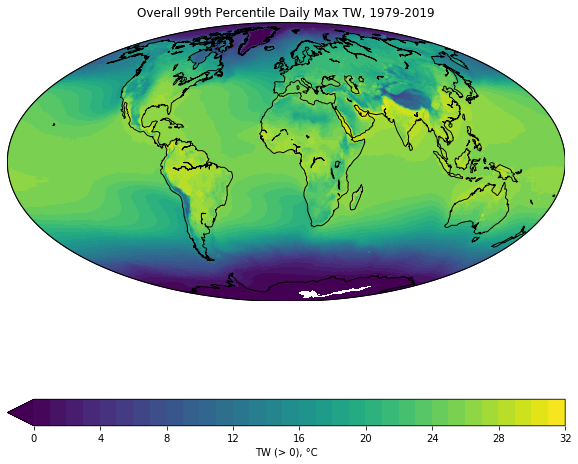

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


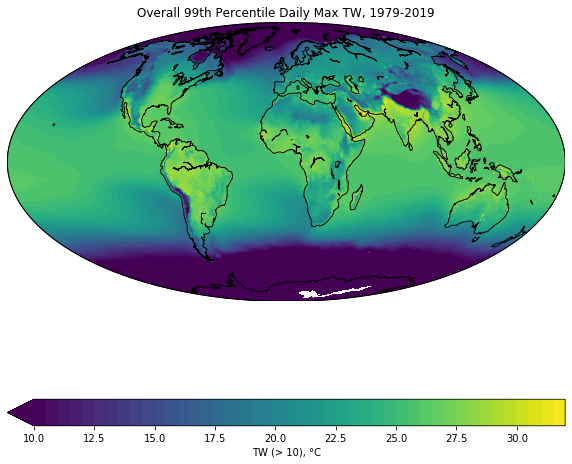

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


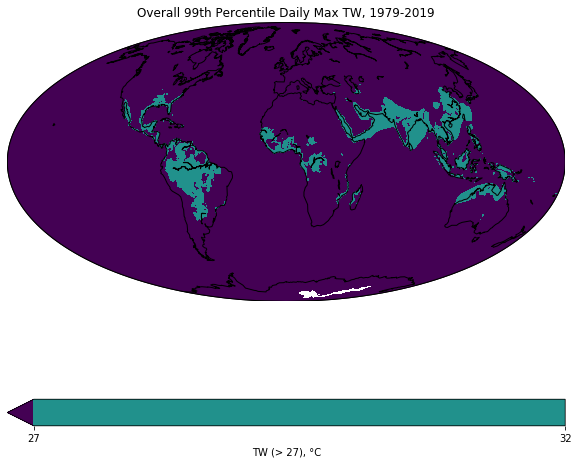

In [22]:
TW_percentile_all_years_99 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_overall.csv')
TW_percentile_all_years_99_transpose = TW_percentile_all_years_99.set_index('Unnamed: 0').transpose()
TW_percentile_all_years_99_np = TW_percentile_all_years_99_transpose.to_numpy()

# get grid of longitudes and latitudes
lat_vals = TW_percentile_all_years_99_transpose.index.values
lon_vals = TW_percentile_all_years_99_transpose.columns.values
lons_2d, lats_2d = np.meshgrid(lon_vals, lat_vals)

# plot
plt.figure(figsize = (10,12))
map_99 = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_99.drawcoastlines()
map_99.drawmapboundary()
m_99 = map_99.contourf(lons_2d, lats_2d, TW_percentile_all_years_99_np, 
                             np.linspace(0, 32, 33), latlon = True, extend = 'min')
cbar_99 = plt.colorbar(m_99, orientation = 'horizontal')
cbar_99.set_label('TW (> 0), °C')
plt.title('Overall 99th Percentile Daily Max TW, 1979-2019')
plt.show()

# plot above 15 only
plt.figure(figsize = (10,12))
map_99 = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_99.drawcoastlines()
map_99.drawmapboundary()
m_99 = map_99.contourf(lons_2d, lats_2d, TW_percentile_all_years_99_np, 
                             np.linspace(10, 32, 45), latlon = True, extend = 'min')
cbar_99 = plt.colorbar(m_99, orientation = 'horizontal')
cbar_99.set_label('TW (> 10), °C')
plt.title('Overall 99th Percentile Daily Max TW, 1979-2019')
plt.show()

# plot above 27 only
plt.figure(figsize = (10,12))
map_99 = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_99.drawcoastlines()
map_99.drawmapboundary()
m_99 = map_99.contourf(lons_2d, lats_2d, TW_percentile_all_years_99_np, 
                             np.linspace(27, 32, 2), latlon = True, extend = 'min')
cbar_99 = plt.colorbar(m_99, orientation = 'horizontal')
cbar_99.set_label('TW (> 27), °C')
plt.title('Overall 99th Percentile Daily Max TW, 1979-2019')
plt.show()

## Peak wet-bulb year

Now look at the year with the highest number of days at or above the 99th percentile.

In [3]:
# function to get the year with the maximum number of days at/above the percentile value. if there are two years tied
# for the maximum number of days, it returns the earlier one
# input data should have at least columns of year and num_at_or_above
# returns the year with the max number of days
def get_year_with_max_days(input_data):
    # get max number of days
    max_days = max(input_data['num_at_or_above'])
    # get locations of where that maximum number of days is (or are, if there are multiple) 
    index_max_days = np.where(input_data['num_at_or_above'] == max_days)
    # get the first index of the max
    first_index_max_days = index_max_days[0][0]
    result_val = input_data['year'].iloc[first_index_max_days]
    return result_val

In [4]:
yearly_days_at_99_perc = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_99_percentile_yearly.csv')
year_with_max_days_at_99_perc = yearly_days_at_99_perc.groupby(['latitude', 'longitude'], 
                                                           as_index = False).apply(get_year_with_max_days)
# format appropriately and save results
year_with_max_days_at_99_perc_df = year_with_max_days_at_99_perc.to_frame().reset_index()
year_with_max_days_at_99_perc_df.columns = ['latitude', 'longitude', 'year']
year_with_max_days_at_99_perc_df.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_year_with_max_days_at_99_percentile.csv',
                                            index = False)

Calculate the number of grid cells with each year as the top one.

In [5]:
num_cells = len(year_with_max_days_at_99_perc_df)
# calculate the number of grid cells with each year
year_counts = pd.DataFrame(year_with_max_days_at_99_perc_df['year'].value_counts(ascending = True)).reset_index()
year_counts.columns = ['year', 'num_cells']
year_counts['frac_cells'] = year_counts['num_cells'] / num_cells
year_counts

,year,num_cells,frac_cells
0,1985,3352,0.003229
1,1986,4555,0.004387
2,1996,5455,0.005254
3,1992,7774,0.007488
4,1987,8079,0.007781
5,1981,8184,0.007883
6,1994,8946,0.008617
7,2001,9781,0.009421
8,1982,9952,0.009585
9,1989,10269,0.009891


Calculate the same thing, but weight each cell by the cosine of its latitude.

In [14]:
# calculate cosine of latitude and weight each cell as the cosine of its latitude
year_with_max_days_at_99_perc_df['cos_latitude'] = np.cos(np.deg2rad(year_with_max_days_at_99_perc_df['latitude']))
year_counts_weighted = year_with_max_days_at_99_perc_df.groupby('year').apply(np.sum)
year_counts_weighted = year_counts_weighted.filter(items = ['cos_latitude'])
year_counts_weighted = year_counts_weighted.rename(columns = {'cos_latitude': 'weighted_cells'})
total_weighted_cells = np.sum(year_counts_weighted['weighted_cells'])
print(total_weighted_cells)
year_counts_weighted['frac_weighted_cells'] = year_counts_weighted['weighted_cells'] / total_weighted_cells
# save results
year_counts_weighted.to_csv('/dx01/sspeizer/data/final_results/year_counts_weighted.csv', index = True)
year_counts_weighted.sort_values(by = 'frac_weighted_cells')

660046.3327928454


,weighted_cells,frac_weighted_cells
year,,
1985,1906.804381,0.002889
1986,2234.020237,0.003385
1996,2431.244353,0.003683
1981,3634.661648,0.005507
1982,4449.918048,0.006742
1979,4697.893900,0.007118
1990,4910.090129,0.007439
1992,4992.795868,0.007564
1987,5011.477755,0.007593


Calculate again but only using land grid points. Again, first obtain unweighted results, then calculate using a weighting of cosine of latitude.

In [33]:
# only use land grid points, then recalculate
# convert to grid
year_with_max_days_at_99_perc_grid = year_with_max_days_at_99_perc_df.pivot(index = 'latitude', columns = 'longitude', 
                                                                      values = 'year')
# get only land values
year_with_max_days_at_99_perc_grid_xar = xr.DataArray(data = year_with_max_days_at_99_perc_grid,
                                                     dims = ['lat', 'lon'],
                                                     coords = {'lat': year_with_max_days_at_99_perc_grid.index.values, 
                                                               'lon': year_with_max_days_at_99_perc_grid.columns.values})
# make a mask to select just the land coordinates
land_mask = regionmask.defined_regions.natural_earth.land_110.mask(year_with_max_days_at_99_perc_grid_xar)
year_with_max_days_at_99_perc_grid_xar_land_mask = year_with_max_days_at_99_perc_grid_xar + land_mask
# split as data frame again
year_with_max_days_at_99_perc_df_land = pd.DataFrame(year_with_max_days_at_99_perc_grid_xar_land_mask.values)
year_with_max_days_at_99_perc_df_land.columns = lon_vals
year_with_max_days_at_99_perc_df_land.index = lat_vals
year_with_max_days_at_99_perc_df_land = year_with_max_days_at_99_perc_df_land.reset_index()
year_with_max_days_at_99_perc_df_land = year_with_max_days_at_99_perc_df_land.rename(columns = {'index': 'latitude'})
year_with_max_days_at_99_perc_df_land = year_with_max_days_at_99_perc_df_land.melt(id_vars = ['latitude'],
                                                                                  var_name = 'longitude',
                                                                                  value_name = 'year')
# remove non-land points
year_with_max_days_at_99_perc_df_land = year_with_max_days_at_99_perc_df_land.dropna()
# now calculate number for each year
num_cells_land = len(year_with_max_days_at_99_perc_df_land)
year_counts_land = pd.DataFrame(year_with_max_days_at_99_perc_df_land['year'].value_counts(ascending = True)).reset_index()
year_counts_land.columns = ['year', 'num_cells']
year_counts_land['frac_cells'] = year_counts_land['num_cells'] / num_cells_land
year_counts_land

,year,num_cells,frac_cells
0,1985.0,207,0.000601
1,1992.0,1092,0.003168
2,1982.0,1212,0.003516
3,2009.0,2041,0.005921
4,1986.0,2168,0.006290
5,1980.0,3087,0.008956
6,2008.0,3196,0.009272
7,2000.0,3288,0.009539
8,1987.0,3289,0.009542
9,1996.0,3532,0.010247


In [39]:
# calculate cosine of latitude and weight each cell as the cosine of its latitude, for only land points
year_with_max_days_at_99_perc_df_land['cos_latitude'] = np.cos(np.deg2rad(year_with_max_days_at_99_perc_df_land['latitude'].astype(float)))
year_counts_land_weighted = year_with_max_days_at_99_perc_df_land.groupby('year').apply(np.sum)
year_counts_land_weighted = year_counts_land_weighted.filter(items = ['cos_latitude'])
year_counts_land_weighted = year_counts_land_weighted.rename(columns = {'cos_latitude': 'weighted_cells'})
total_weighted_cells_land = np.sum(year_counts_land_weighted['weighted_cells'])
print(total_weighted_cells_land)
year_counts_land_weighted['frac_weighted_cells'] = year_counts_land_weighted['weighted_cells'] / total_weighted_cells_land
year_counts_land_weighted.sort_values(by = 'frac_weighted_cells')

190578.35838401856


,weighted_cells,frac_weighted_cells
year,,
1985.0,165.617227,0.000869
1982.0,578.814731,0.003037
1992.0,610.449091,0.003203
1986.0,1074.083785,0.005636
2009.0,1403.721468,0.007366
1996.0,1413.880047,0.007419
1980.0,1444.568860,0.007580
1990.0,1546.402196,0.008114
2008.0,1973.528715,0.010355


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


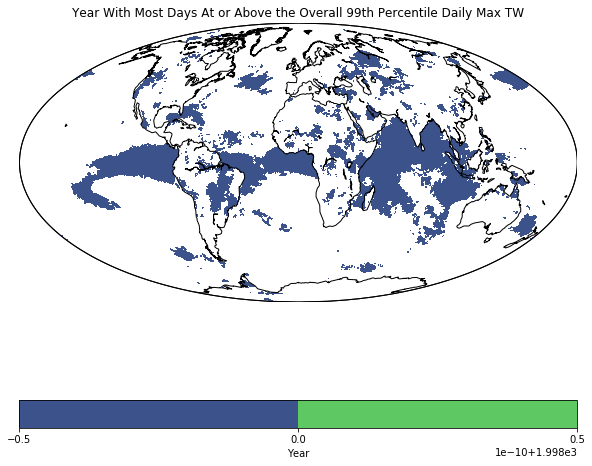

In [44]:
# visualize the places with 1998 as the top year
# convert to numpy array
year_with_max_days_at_99_perc_grid_np = year_with_max_days_at_99_perc_grid.to_numpy()

# get grid of longitudes and latitudes
lat_vals = year_with_max_days_at_99_perc_grid.index.values
lon_vals = year_with_max_days_at_99_perc_grid.columns.values
lons_2d, lats_2d = np.meshgrid(lon_vals, lat_vals)

plt.figure(figsize = (10,12))
map_year2 = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_year2.drawcoastlines()
map_year2.drawmapboundary()
m_year2 = map_year2.contourf(lons_2d, lats_2d, np.where(year_with_max_days_at_99_perc_grid == 1998, 
                                                        year_with_max_days_at_99_perc_grid, 
                                                        np.nan), latlon = True)
cbar_year2 = plt.colorbar(m_year2, orientation = 'horizontal')
cbar_year2.set_label('Year')
plt.title('Year With Most Days At or Above the Overall 99th Percentile Daily Max TW')
plt.show()

## Number of years to get to 75% of extreme wet-bulb days

Now, for each grid cell, rank the years by their number of days at or above the 99th percentile. Then find how many years down this list we need to go before we reach 75% of the days at or above the 99th percentile across all the years.

In [45]:
# first compute the total number of days at or above the 99th percentile across all years
total_at_or_above = yearly_days_at_99_perc.groupby(['latitude', 'longitude']).apply(np.sum)
np.unique(total_at_or_above['num_at_or_above'])

array([  0., 150., 151.])

In [46]:
# look at where this is 151 not 150
total_at_or_above[total_at_or_above['num_at_or_above'] == 151]

,,longitude,latitude,num_at_or_above,year,year_since_1979
latitude,longitude,,,,,
-87.75,37.00,1517.00,-3597.75,151.0,81959.0,820.0
-73.75,144.00,5904.00,-3023.75,151.0,81959.0,820.0
-72.75,59.75,2449.75,-2982.75,151.0,81959.0,820.0
-67.75,102.25,4192.25,-2777.75,151.0,81959.0,820.0
-61.00,168.25,6898.25,-2501.00,151.0,81959.0,820.0
...,...,...,...,...,...,...
66.75,85.75,3515.75,2736.75,151.0,81959.0,820.0
67.25,37.00,1517.00,2757.25,151.0,81959.0,820.0
72.50,35.25,1445.25,2972.50,151.0,81959.0,820.0


In [47]:
# function to get the year in which we get to a certain number of total days above the percentile of interest, which 
# is set inside the function itself so needs to be changed when desired. this is calculated by arranging the years
# by the number of days that they have at/above the percentile of interest, then seeing how many years down that list
# you have to go before getting to the desired number of total days above that percentile
# input_data should have columns for num_at_or_above and year
# returns the number of years that we need to go through before we hit/exceed that threshold 
def get_num_years_till_frac_days_non_chronological(input_data):
    # there are 150 or 151 days in total at or above the 99th percentile across all years, and we want to find 75% of 
    # those, which corresponds to (rounded, for both cases) 113 days
    # adjust this if a different percentile is used or a different fraction of the days is desired
    thresh_val = 113
    # sort the input values by their number of days at/above the percentile
    input_data_sorted = input_data.sort_values(by = 'num_at_or_above', ascending = False)
    # get cumulative sum of the values in the input
    input_cumsum = input_data_sorted.cumsum()
    # find the index where the cumulative sum of the number of days at or above the threshold is greater than or
    # equal to the threshold value
    indexes_all_at_above = np.where(input_cumsum['num_at_or_above'] >= thresh_val)
    # value to return, NA if not found if there were no days at or above the value (meaning that the data was all NAs)
    result_val = np.nan
    if (len(indexes_all_at_above[0]) > 0):
        index_first_at_above = indexes_all_at_above[0][0]
        # add 1 to get the number of years
        result_val = index_first_at_above + 1
    # return the result
    return result_val

In [48]:
# calculate number of years till we get to 75% of all the days
num_years_till_75_percent_days_at_99_perc = yearly_days_at_99_perc.groupby(['latitude', 'longitude'], 
                                            as_index = False).apply(get_num_years_till_frac_days_non_chronological)
num_years_till_75_percent_days_at_99_perc_df = num_years_till_75_percent_days_at_99_perc.to_frame().reset_index()
num_years_till_75_percent_days_at_99_perc_df.columns = ['latitude', 'longitude', 'num_years']

In [49]:
# save results
num_years_till_75_percent_days_at_99_perc_df.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_num_years_till_75_percent_days_at_99_percentile.csv',
                                            index = False)

Compute the number/fraction of cells that require each number of years, as well as the fraction of cells that require less than 15, 10, and 5 years.

In [50]:
num_cells = len(num_years_till_75_percent_days_at_99_perc_df.dropna())
num_year_counts = pd.DataFrame(num_years_till_75_percent_days_at_99_perc_df['num_years'].value_counts(ascending = True)).reset_index()
num_year_counts.columns = ['num_years', 'num_cells']
num_year_counts['frac_cells'] = num_year_counts['num_cells'] / num_cells
num_year_counts = num_year_counts.sort_values(by = 'num_years')
print(num_year_counts)
frac_cells_less_than_15 = np.sum(num_year_counts[num_year_counts['num_years'] < 15]['num_cells']) / num_cells
print(frac_cells_less_than_15)
frac_cells_less_than_10 = np.sum(num_year_counts[num_year_counts['num_years'] < 10]['num_cells']) / num_cells
print(frac_cells_less_than_10)
frac_cells_less_than_5 = np.sum(num_year_counts[num_year_counts['num_years'] < 5]['num_cells']) / num_cells
print(frac_cells_less_than_5)
np.sum(num_year_counts['frac_cells'])

    num_years  num_cells  frac_cells
4         2.0       7318    0.007121
5         3.0      12246    0.011917
7         4.0      17651    0.017176
8         5.0      21990    0.021399
9         6.0      24698    0.024034
10        7.0      29909    0.029105
12        8.0      37928    0.036908
13        9.0      52229    0.050825
15       10.0      71337    0.069419
16       11.0      80346    0.078186
17       12.0      81909    0.079707
18       13.0      86080    0.083766
20       14.0      91269    0.088815
21       15.0     100127    0.097435
22       16.0     103127    0.100354
19       17.0      88406    0.086029
14       18.0      62504    0.060824
11       19.0      33991    0.033077
6        20.0      16585    0.016139
3        21.0       6264    0.006096
2        22.0       1597    0.001554
1        23.0        114    0.000111
0        24.0          4    0.000004
0.5983774299868921
0.1984850563773502
0.03621443147283699


1.0

Calculate the same values, but weighting each cell by the cosine of its latitude.

In [51]:
# weighting by cos(lat)
num_years_till_75_percent_days_at_99_perc_df['cos_latitude'] = np.cos(np.deg2rad(num_years_till_75_percent_days_at_99_perc_df['latitude']))
num_year_counts_weighted = num_years_till_75_percent_days_at_99_perc_df.groupby('num_years').apply(np.sum)
num_year_counts_weighted = num_year_counts_weighted.filter(items = ['cos_latitude'])
num_year_counts_weighted = num_year_counts_weighted.rename(columns = {'cos_latitude': 'weighted_cells'}).reset_index()
total_weighted_cells_num_years = np.sum(num_year_counts_weighted['weighted_cells'])
print(total_weighted_cells_num_years)
print(num_year_counts_weighted)
print(np.sum(num_year_counts_weighted[num_year_counts_weighted['num_years'] < 15]['weighted_cells']) / total_weighted_cells_num_years)
print(np.sum(num_year_counts_weighted[num_year_counts_weighted['num_years'] < 10]['weighted_cells']) / total_weighted_cells_num_years)
print(np.sum(num_year_counts_weighted[num_year_counts_weighted['num_years'] < 5]['weighted_cells']) / total_weighted_cells_num_years)


658325.3518079434
    num_years  weighted_cells
0         2.0     7248.751899
1         3.0    11894.078676
2         4.0    15959.390557
3         5.0    18709.115804
4         6.0    19746.043382
5         7.0    23187.699822
6         8.0    29208.254559
7         9.0    40672.822350
8        10.0    55102.540584
9        11.0    62408.523886
10       12.0    62362.717745
11       13.0    61651.415274
12       14.0    57430.194518
13       15.0    54379.907806
14       16.0    48361.540343
15       17.0    39433.493411
16       18.0    26512.530597
17       19.0    14195.519243
18       20.0     6826.302312
19       21.0     2398.619165
20       22.0      573.696253
21       23.0       58.453442
22       24.0        3.740184
0.7072210538075194
0.25310609198086326
0.05332047601572697


Calculate the same values, but only for the land grid cells.

In [53]:
# only use land grid points, then recalculate
# convert to grid
num_years_till_75_percent_days_at_99_perc_grid = num_years_till_75_percent_days_at_99_perc_df.pivot(index = 'latitude', 
                                                                                    columns = 'longitude', 
                                                                                    values = 'num_years')

# get only land values
num_years_till_75_percent_days_at_99_perc_grid_xar = xr.DataArray(data = num_years_till_75_percent_days_at_99_perc_grid,
                                                     dims = ['lat', 'lon'],
                                                     coords = {'lat': num_years_till_75_percent_days_at_99_perc_grid.index.values,
                                                            'lon': num_years_till_75_percent_days_at_99_perc_grid.columns.values})
# make a mask to select just the land coordinates
land_mask = regionmask.defined_regions.natural_earth.land_110.mask(num_years_till_75_percent_days_at_99_perc_grid_xar)
num_years_till_75_percent_days_at_99_perc_grid_xar_land_mask = num_years_till_75_percent_days_at_99_perc_grid_xar + land_mask
# split as data frame again
num_years_till_75_percent_days_at_99_perc_df_land = pd.DataFrame(num_years_till_75_percent_days_at_99_perc_grid_xar_land_mask.values)
num_years_till_75_percent_days_at_99_perc_df_land.columns = lon_vals
num_years_till_75_percent_days_at_99_perc_df_land.index = lat_vals
num_years_till_75_percent_days_at_99_perc_df_land = num_years_till_75_percent_days_at_99_perc_df_land.reset_index()
num_years_till_75_percent_days_at_99_perc_df_land = num_years_till_75_percent_days_at_99_perc_df_land.rename(columns = {'index': 'latitude'})
num_years_till_75_percent_days_at_99_perc_df_land = num_years_till_75_percent_days_at_99_perc_df_land.melt(id_vars = ['latitude'],
                                                                                  var_name = 'longitude',
                                                                                  value_name = 'num_years')
# remove non-land points
num_years_till_75_percent_days_at_99_perc_df_land = num_years_till_75_percent_days_at_99_perc_df_land.dropna()
# now calculate number for each year
num_cells_land = len(num_years_till_75_percent_days_at_99_perc_df_land)
num_year_counts_land = pd.DataFrame(num_years_till_75_percent_days_at_99_perc_df_land['num_years'].value_counts(ascending = True)).reset_index()
num_year_counts_land.columns = ['num_years', 'num_cells']
num_year_counts_land['frac_cells'] = num_year_counts_land['num_cells'] / num_cells_land
num_year_counts_land = num_year_counts_land.sort_values(by = 'num_years')
print(num_year_counts_land)
frac_cells_less_than_15_land = np.sum(num_year_counts_land[num_year_counts_land['num_years'] < 15]['num_cells']) / num_cells_land
print(frac_cells_less_than_15_land)
frac_cells_less_than_10_land = np.sum(num_year_counts_land[num_year_counts_land['num_years'] < 10]['num_cells']) / num_cells_land
print(frac_cells_less_than_10_land)
frac_cells_less_than_5_land = np.sum(num_year_counts_land[num_year_counts_land['num_years'] < 5]['num_cells']) / num_cells_land
print(frac_cells_less_than_5_land)
np.sum(num_year_counts_land['frac_cells'])

    num_years  num_cells  frac_cells
2         2.0         94    0.000281
3         3.0        143    0.000428
6         4.0        533    0.001595
5         5.0        443    0.001326
7         6.0        795    0.002380
9         7.0       1589    0.004756
10        8.0       2901    0.008684
11        9.0       4558    0.013644
13       10.0       6391    0.019130
14       11.0       9111    0.027272
16       12.0      15029    0.044987
17       13.0      25567    0.076530
19       14.0      40613    0.121568
21       15.0      56450    0.168973
22       16.0      65198    0.195159
20       17.0      53868    0.161244
18       18.0      31816    0.095236
15       19.0      12892    0.038590
12       20.0       4575    0.013694
8        21.0       1235    0.003697
4        22.0        240    0.000718
1        23.0         32    0.000096
0        24.0          4    0.000012
0.32258132107268683
0.033094166913615726
0.0023048578621096332


1.0

In [54]:
# weighting by cos(lat) just for land cells
num_years_till_75_percent_days_at_99_perc_df_land['cos_latitude'] = np.cos(np.deg2rad(num_years_till_75_percent_days_at_99_perc_df_land['latitude']))
num_year_counts_land_weighted = num_years_till_75_percent_days_at_99_perc_df_land.groupby('num_years').apply(np.sum)
num_year_counts_land_weighted = num_year_counts_land_weighted.filter(items = ['cos_latitude'])
num_year_counts_land_weighted = num_year_counts_land_weighted.rename(columns = {'cos_latitude': 'weighted_cells'}).reset_index()
total_weighted_cells_num_years_land = np.sum(num_year_counts_land_weighted['weighted_cells'])
print(total_weighted_cells_num_years_land)
print(num_year_counts_land_weighted)
print(np.sum(num_year_counts_land_weighted[num_year_counts_land_weighted['num_years'] < 15]['weighted_cells']) / total_weighted_cells_num_years_land)
print(np.sum(num_year_counts_land_weighted[num_year_counts_land_weighted['num_years'] < 10]['weighted_cells']) / total_weighted_cells_num_years_land)
print(np.sum(num_year_counts_land_weighted[num_year_counts_land_weighted['num_years'] < 5]['weighted_cells']) / total_weighted_cells_num_years_land)


188857.3773991745
    num_years  weighted_cells
0         2.0       93.041036
1         3.0      140.206213
2         4.0      522.720860
3         5.0      432.231738
4         6.0      733.235249
5         7.0     1475.332065
6         8.0     2706.530115
7         9.0     4220.012885
8        10.0     5508.359624
9        11.0     7526.361079
10       12.0    11152.336329
11       13.0    16368.940693
12       14.0    22633.647649
13       15.0    28676.023385
14       16.0    30577.084456
15       17.0    26402.447577
16       18.0    17337.632449
17       19.0     7996.154645
18       20.0     3195.991804
19       21.0      930.501897
20       22.0      197.160578
21       23.0       27.684893
22       24.0        3.740184
0.3892511722102983
0.054661937499110656
0.004002851882451696


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


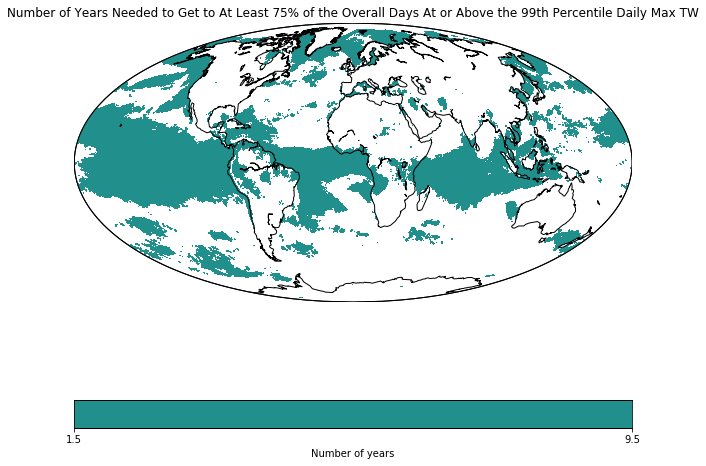

In [55]:
# visualize the grid cells that require less than 10 years
# convert to numpy array
num_years_till_75_percent_days_at_99_perc_grid_np = num_years_till_75_percent_days_at_99_perc_grid.to_numpy()

# get grid of longitudes and latitudes
lat_vals = num_years_till_75_percent_days_at_99_perc_grid.index.values
lon_vals = num_years_till_75_percent_days_at_99_perc_grid.columns.values
lons_2d, lats_2d = np.meshgrid(lon_vals, lat_vals)

plt.figure(figsize = (10,12))
map_year_num = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_year_num.drawcoastlines()
map_year_num.drawmapboundary()
m_year_num = map_year_num.contourf(lons_2d, lats_2d, num_years_till_75_percent_days_at_99_perc_grid_np, 
                                   np.linspace(1.5, 9.5, 2), latlon = True, cmap = "viridis_r")
cbar_year_num = plt.colorbar(m_year_num, orientation = 'horizontal')
cbar_year_num.set_label('Number of years')
plt.title('Number of Years Needed to Get to At Least 75% of the Overall Days At or Above the 99th Percentile Daily Max TW')
plt.show()

## Trends in number of days at/above the 99th percentile value

Get trends in the number of days at/above the 99th percentile value across the years. This was not directly used in the paper, but is a supplemental calculation and analysis done for our own comparison.

In [56]:
# function to get the coefficient, r squared, and p value of the coefficient of the linear model fitting 
# the number of days at/above a threshold vs year for given input data. 
# input data should have at least columns corresponding to 'year_since_1979' and 'num_at_or_above'
# returns [coefficient, rsquared, coefficient p value]
def get_model_results_num_days(input_data):
    model = sm.OLS(input_data['num_at_or_above'], sm.add_constant(input_data['year_since_1979'])).fit()
    return [model.params[1], model.rsquared, model.pvalues[1]]

In [58]:
yearly_days_at_99_perc = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_99_percentile_yearly.csv')
model_vals_days_99 = yearly_days_at_99_perc.groupby(['latitude', 'longitude'], 
                                                    as_index = False).apply(get_model_results_num_days)
# format appropriately
model_vals_days_99_df = model_vals_days_99.to_frame()
model_vals_days_99_df = model_vals_days_99_df.reset_index()
model_vals_days_99_df.columns = ['latitude', 'longitude', 'coef_rsquared_pval']
# create new data frame to break up the coefficient and r squared from how they are currently present as a list
model_vals_days_99_df_2 = pd.DataFrame(model_vals_days_99_df['coef_rsquared_pval'].to_list(), 
                                       columns = ['coef', 'rsquared', 'coef_pval'])
model_vals_days_99_df_2['latitude'] = model_vals_days_99_df['latitude']
model_vals_days_99_df_2['longitude'] = model_vals_days_99_df['longitude']

# store as csv
model_vals_days_99_df_2.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_99_percentile_linear_trends.csv', 
                                index = False)

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [59]:
model_vals_days_99_df_2 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_99_percentile_linear_trends.csv')
# convert into a grid again in order to put results on a map
coef_info_grid_days_99 = model_vals_days_99_df_2.pivot(index = 'latitude', columns = 'longitude', values = 'coef')
pval_info_grid_days_99 = model_vals_days_99_df_2.pivot(index = 'latitude', columns = 'longitude', values = 'coef_pval')
# convert to numpy arrays
coef_info_grid_days_99_np = coef_info_grid_days_99.to_numpy()
pval_info_grid_days_99_np = pval_info_grid_days_99.to_numpy()

# get grid of longitudes and latitudes
lat_vals = coef_info_grid_days_99.index.values
lon_vals = coef_info_grid_days_99.columns.values
lons_2d, lats_2d = np.meshgrid(lon_vals, lat_vals) 

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


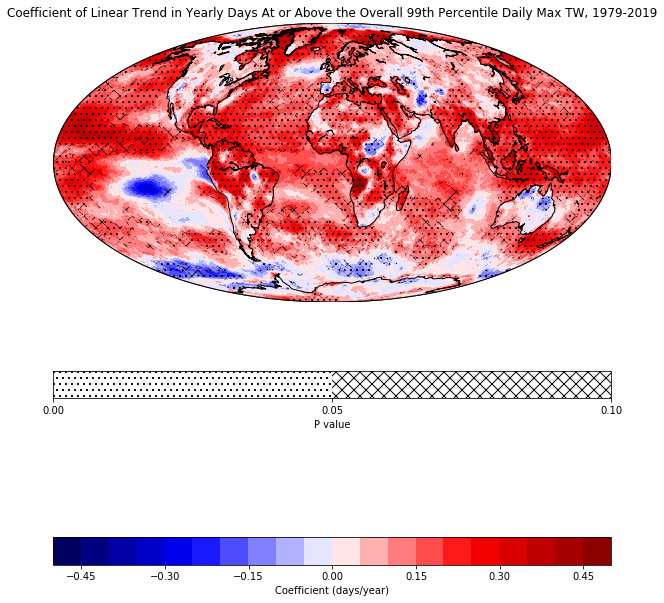

In [60]:
# plot
plt.figure(figsize = (10,12))
map_coefs_days = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_coefs_days.drawcoastlines()
map_coefs_days.drawmapboundary()
m_coefs_days = map_coefs_days.contourf(lons_2d, lats_2d, coef_info_grid_days_99_np, np.linspace(-0.5, 0.5, 21), 
                                       latlon = True, cmap = 'seismic')
cbar_coefs_days = plt.colorbar(m_coefs_days, orientation = 'horizontal')
cbar_coefs_days.set_label('Coefficient (days/year)')
m_pval_days = map_coefs_days.contourf(lons_2d, lats_2d, pval_info_grid_days_99_np, [0, 0.05, 0.1], 
                                      colors = 'none', hatches = ['..', 'xx'], latlon = True)
cbar_pval_days = plt.colorbar(m_pval_days, orientation = 'horizontal')
cbar_pval_days.set_label('P value')
plt.title('Coefficient of Linear Trend in Yearly Days At or Above the Overall 99th Percentile Daily Max TW, 1979-2019')
plt.show()


# Day-to-day clustering

Exploring the clustering of days over the overall 99th percentile at a sub-year time frame. Specifically looking at the extreme wet-bulb concentration, or the number of days in a two-week window surrounding each 99th percentile day that are also above the 99th percentile in wet-bulb temperature.

In [3]:
# code to loop over all the years and coalesce all TW daily max values for additional analysis

# will store all the values as an array
TW_all_years_list = []

# loop through the year numbers to combine all results
yr_nums = np.linspace(1979, 2019, 41, dtype = int)
for yr in yr_nums:
    curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % yr
    # load the data for this year
    curr_data = nc.Dataset(curr_filename)
    time_info = curr_data.variables['time']
    times = time_info[:]
    lat_info = curr_data.variables['latitude']
    lats = lat_info[:]
    lon_info = curr_data.variables['longitude']
    lons = lon_info[:]
    TW_info = curr_data.variables['TW']
    TWs = TW_info[:]
    
    # append current results to the end of the list
    TW_all_years_list.append(TWs)

# now stack the resulting arrays to create a 3D array of results
TW_all_years = np.concatenate(TW_all_years_list, axis = 0)

# load results for the overall 99th percentile value across all years
TW_percentile_all_years_99 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_overall.csv')

In [4]:
TW_percentile_all_years_99_np = TW_percentile_all_years_99.set_index('Unnamed: 0').to_numpy()

Calculate the extreme wet-bulb concentration.

In [5]:
# get latitude and longitude values from one file that is in the set for all the years
curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_2000_0UTC.nc'
# load the data for this year
curr_data = nc.Dataset(curr_filename)
lat_info = curr_data.variables['latitude']
lats = lat_info[:]
lon_info = curr_data.variables['longitude']
lons = lon_info[:]

# data frame to store the results
nearby_99_perc_days_2_week_window_info = pd.DataFrame()
nearby_99_perc_days_2_week_window_summarized = pd.DataFrame() # summarized info for each location

# variable to store time window on either side, in days - here 15 days, 1 week on either side of the day of interest
window_days = 15

# loop through the latitude and longitude dimensions
for i in range(TW_all_years.shape[1]):
        for j in range(TW_all_years.shape[2]):
            # just TW values at this location
            curr_lat_lon_TWs = TW_all_years[:, i, j]
            # 99th percentile value for this location
            curr_TW_99 = TW_percentile_all_years_99_np[i, j]
            # find the positions of days at or above the 99th percentile threshold for this day
            days_at_above_locs = np.where(curr_lat_lon_TWs >= curr_TW_99)
            # flag the values at or above
            days_at_above_flagged = pd.Series(np.where(curr_lat_lon_TWs >= curr_TW_99, 1, 0))
            
            # for each day, find how many values in the window around that day are at or above the 99th percentile 
            # value
            days_at_above_sum = days_at_above_flagged.rolling(window_days, center = True, min_periods = 1).sum()
            
            # get the results for each of the 99th percentile or above days
            days_at_above_sum_99_perc_days = days_at_above_sum[days_at_above_locs[0]]
            
            # now calculate the mean in the 2 week window surrounding each day, and store the results for the days at 
            # or above the 99th percentile value only
            days_mean_window = pd.Series(curr_lat_lon_TWs).rolling(window_days, center = True, min_periods = 1).mean()
            days_mean_window_99_perc_days = days_mean_window[days_at_above_locs[0]]
            
#             # store as data frame
#             curr_days_at_above_window_info = pd.DataFrame(data = {'day_position': days_at_above_locs[0], 
#                                                         'surrounding_99_perc_days': days_at_above_sum_99_perc_days,
#                                                          'surrounding_TW_avg': days_mean_window_99_perc_days})
#             curr_days_at_above_window_info = curr_days_at_above_window_info.reset_index(drop = True)
#             # add columns for current latitude and longitude
#             curr_days_at_above_window_info['longitude'] = lons[i]
#             curr_days_at_above_window_info['latitude'] = lats[j]
#             # add to overall dataframe
#             nearby_99_perc_days_2_week_window_info = nearby_99_perc_days_2_week_window_info.append(curr_days_at_above_window_info)
            
            # summarize across all days
            mean_num_surrounding_99_perc_days = np.mean(days_at_above_sum_99_perc_days)
            mean_days_mean_window_99_perc_days = np.mean(days_mean_window_99_perc_days)
            curr_days_at_above_window_summarized = pd.DataFrame(data = {'latitude': lats[j],
                                                                       'longitude': lons[i],
                                            'mean_num_surrounding_99_perc_days': mean_num_surrounding_99_perc_days,
                                            'mean_surrounding_TW_avg': mean_days_mean_window_99_perc_days},
                                                               index = [0])
            # add to overall dataframe
            nearby_99_perc_days_2_week_window_summarized = nearby_99_perc_days_2_week_window_summarized.append(curr_days_at_above_window_summarized)
            
            
# reset index 
# nearby_99_perc_days_2_week_window_info = nearby_99_perc_days_2_week_window_info.reset_index(drop = True)
nearby_99_perc_days_2_week_window_summarized = nearby_99_perc_days_2_week_window_summarized.reset_index(drop = True)

nearby_99_perc_days_2_week_window_summarized.to_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_days_2_week_window_info_summarized.csv')

Join to the overall 99th percentile results.

In [6]:
# read csv of results
TW_percentile_all_years_99 = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_percentile_overall.csv')
nearby_99_perc_days_2_week_window_summarized = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_99_perc_days_2_week_window_info_summarized.csv')
nearby_99_perc_days_2_week_window_summarized = nearby_99_perc_days_2_week_window_summarized.drop('Unnamed: 0', 
                                                                                                 axis = 'columns')
# edit percentile results and join
TW_percentile_all_years_longer = TW_percentile_all_years_99.rename(columns = {'Unnamed: 0' : 'longitude'}) 
TW_percentile_all_years_longer = pd.melt(TW_percentile_all_years_longer, id_vars = ['longitude'], var_name = 'latitude', 
                                          value_name = 'TW_99_percentile')
TW_percentile_all_years_longer['latitude'] = TW_percentile_all_years_longer['latitude'].astype(float)
# join to the data on the nearby days
nearby_99_perc_days_2_week_window_summarized_wpercs = pd.merge(nearby_99_perc_days_2_week_window_summarized, 
                                                               TW_percentile_all_years_longer, 
                                                               on = ['longitude', 'latitude'])


Calculate the fraction of grid cells with extreme wet-bulb concentration greater than 4/5/7, and the mean extreme wet-bulb concentration (weighted and unweighted).

In [7]:
num_nearby_99_perc_days_2_week_window = nearby_99_perc_days_2_week_window_summarized_wpercs.filter(items = ['latitude', 
                                                                                                         'longitude', 
                                                                        'mean_num_surrounding_99_perc_days']).dropna()
num_cells = len(num_nearby_99_perc_days_2_week_window)
frac_more_than_4 = len(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 4]) / num_cells
print(frac_more_than_4)
frac_more_than_5 = len(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 5]) / num_cells
print(frac_more_than_5)
frac_more_than_7 = len(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 7]) / num_cells
print(frac_more_than_7)
print(np.nanmean(num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days']))
# weight by cosine of latitude
num_nearby_99_perc_days_2_week_window['cos_latitude'] = np.cos(np.deg2rad(num_nearby_99_perc_days_2_week_window['latitude']))
print(np.average(num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'], 
                 weights = num_nearby_99_perc_days_2_week_window['cos_latitude']))

0.4864956127162624
0.1925889596342649
0.03176438189268695
4.090213806622048
4.142144340129321


Calculate the same fractions, but weighted by cosine of latitude.

In [8]:
# weighted by cos(lat)
# get the total number of weighted points
total_cells_weighted_tw_conc = np.sum(num_nearby_99_perc_days_2_week_window['cos_latitude'])
# get fraction above 5
print(np.sum(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 5]['cos_latitude']) / total_cells_weighted_tw_conc)
# also above 4 and 7
print(np.sum(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 4]['cos_latitude']) / total_cells_weighted_tw_conc)
print(np.sum(num_nearby_99_perc_days_2_week_window[num_nearby_99_perc_days_2_week_window['mean_num_surrounding_99_perc_days'] > 7]['cos_latitude']) / total_cells_weighted_tw_conc)

0.21639138875675318
0.4925200140936479
0.038546633640172315


Repeat analysis just for land grid cells.

In [11]:
# now for just land points
# convert to grid
mean_num_surrounding_99_perc_days_grid = nearby_99_perc_days_2_week_window_summarized_wpercs.pivot(index = 'latitude', 
                                                                        columns = 'longitude', 
                                                                        values = 'mean_num_surrounding_99_perc_days')
# convert to numpy array
mean_num_surrounding_99_perc_days_grid_np = mean_num_surrounding_99_perc_days_grid.to_numpy()

# get grid of longitudes and latitudes
lat_vals = mean_num_surrounding_99_perc_days_grid.index.values
lon_vals = mean_num_surrounding_99_perc_days_grid.columns.values
lons_2d, lats_2d = np.meshgrid(lon_vals, lat_vals)

# get only land values
mean_num_surrounding_99_perc_days_xar = xr.DataArray(data = mean_num_surrounding_99_perc_days_grid_np, 
                                                     dims = ['lat', 'lon'], 
                                                     coords = {'lat': lat_vals, 'lon': lon_vals})
    
# make a mask to select just the land coordinates
land_mask = regionmask.defined_regions.natural_earth.land_110.mask(mean_num_surrounding_99_perc_days_xar)
mean_num_surrounding_99_perc_days_xar_land_mask = mean_num_surrounding_99_perc_days_xar + land_mask

mean_num_surrounding_99_perc_days_land = pd.DataFrame(mean_num_surrounding_99_perc_days_xar_land_mask.values)
mean_num_surrounding_99_perc_days_land.index = lat_vals
mean_num_surrounding_99_perc_days_land.columns = lon_vals
mean_num_surrounding_99_perc_days_land = mean_num_surrounding_99_perc_days_land.reset_index()
mean_num_surrounding_99_perc_days_land = mean_num_surrounding_99_perc_days_land.rename(columns = {'index': 'latitude'})
mean_num_surrounding_99_perc_days_land = mean_num_surrounding_99_perc_days_land.melt(id_vars = ['latitude'],
                                                                                    var_name = 'longitude',
                                                                value_name = 'mean_num_surrounding_99_perc_days')
mean_num_surrounding_99_perc_days_land = mean_num_surrounding_99_perc_days_land.dropna()
num_cells_land = len(mean_num_surrounding_99_perc_days_land)
frac_more_than_4_land = len(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 4]) / num_cells_land
print(frac_more_than_4_land)
frac_more_than_5_land = len(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 5]) / num_cells_land
print(frac_more_than_5_land)
frac_more_than_7_land = len(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 7]) / num_cells_land
print(frac_more_than_7_land)
print(np.nanmean(mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days']))
# weight by cosine of latitude
mean_num_surrounding_99_perc_days_land['cos_latitude'] = np.cos(np.deg2rad(mean_num_surrounding_99_perc_days_land['latitude']))
print(np.average(mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'], 
                 weights = mean_num_surrounding_99_perc_days_land['cos_latitude']))

0.3993899609970157
0.0611685330028706
0.0010985491368756305
3.7139362836478713
3.402208165119269


In [12]:
# just land points but weighted by cos(lat)
# get the total number of weighted points
total_cells_weighted_tw_conc_land = np.sum(mean_num_surrounding_99_perc_days_land['cos_latitude'])
print(total_cells_weighted_tw_conc_land)
# get fraction above 5
print(np.sum(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 5]['cos_latitude']) / total_cells_weighted_tw_conc_land)
# also above 4 and 7
print(np.sum(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 4]['cos_latitude']) / total_cells_weighted_tw_conc_land)
print(np.sum(mean_num_surrounding_99_perc_days_land[mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days'] > 7]['cos_latitude']) / total_cells_weighted_tw_conc_land)
mean_num_surrounding_99_perc_days_land['test_weighted'] = mean_num_surrounding_99_perc_days_land['mean_num_surrounding_99_perc_days']*mean_num_surrounding_99_perc_days_land['cos_latitude']

188857.37739917258
0.03976206433593627
0.25338285791861764
0.0013981526643210296


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


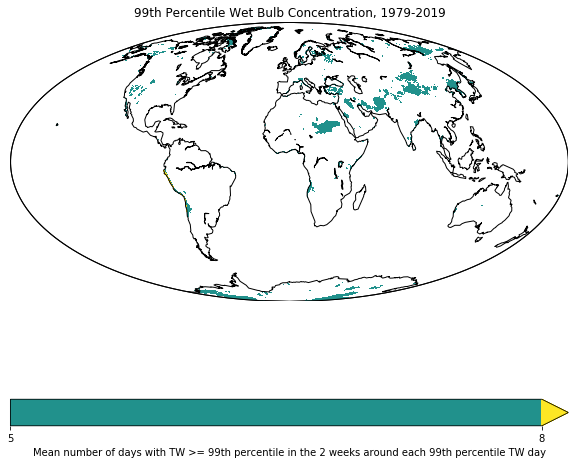

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


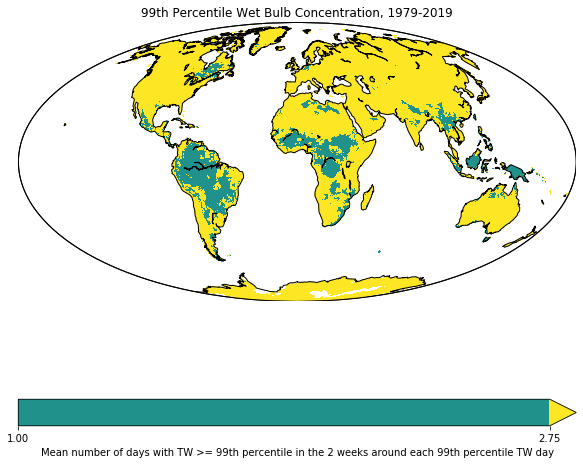

In [13]:
# look at locations with high and low EWC on a map
plt.figure(figsize = (10,12))
map_num_surrounding_land = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_num_surrounding_land.drawcoastlines()
map_num_surrounding_land.drawmapboundary()
m_num_surrounding_land = map_num_surrounding_land.contourf(lons_2d, lats_2d, mean_num_surrounding_99_perc_days_xar_land_mask, 
                                                           np.linspace(5, 8, 2), extend = 'max', latlon = True)
cbar_num_surrounding_land = plt.colorbar(m_num_surrounding_land, orientation = 'horizontal')
cbar_num_surrounding_land.set_label('Mean number of days with TW >= 99th percentile in the 2 weeks around each 99th percentile TW day')
plt.title('99th Percentile Wet Bulb Concentration, 1979-2019')
plt.show()

plt.figure(figsize = (10,12))
map_num_surrounding_land = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_num_surrounding_land.drawcoastlines()
map_num_surrounding_land.drawmapboundary()
m_num_surrounding_land = map_num_surrounding_land.contourf(lons_2d, lats_2d, mean_num_surrounding_99_perc_days_xar_land_mask, 
                                                 np.linspace(1, 2.75, 2), extend = 'max', latlon = True)
cbar_num_surrounding_land = plt.colorbar(m_num_surrounding_land, orientation = 'horizontal')
cbar_num_surrounding_land.set_label('Mean number of days with TW >= 99th percentile in the 2 weeks around each 99th percentile TW day')
plt.title('99th Percentile Wet Bulb Concentration, 1979-2019')
plt.show()

# Wet-bulb and precipitation for desert regions

Looking at time series of daily maximum wet-bulb temperatures and precipitation for regions with high extreme wet-bulb concentration.

In [14]:
# find locations with TW concentration > 7 and between 15 and 40 degrees N, 0 and 120 degrees E
selected_nearby_99_perc_days = nearby_99_perc_days_2_week_window_summarized_wpercs[(nearby_99_perc_days_2_week_window_summarized_wpercs['mean_num_surrounding_99_perc_days'] > 7) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] > 15) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] < 40) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] > 0) &
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] < 120)]
selected_nearby_99_perc_days = selected_nearby_99_perc_days.sort_values(by = ['mean_num_surrounding_99_perc_days'],
                                                                       ascending = False)
print(selected_nearby_99_perc_days[0:20])

# around 32 N, 63 E seems like a good spot for the Afghanistan region

# try narrowing in on the Sahara region a bit more 
selected_nearby_99_perc_days = nearby_99_perc_days_2_week_window_summarized_wpercs[(nearby_99_perc_days_2_week_window_summarized_wpercs['mean_num_surrounding_99_perc_days'] > 6) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] > 15) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] < 30) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] > 0) &
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] < 40)]
selected_nearby_99_perc_days = selected_nearby_99_perc_days.sort_values(by = ['mean_num_surrounding_99_perc_days'],
                                                                       ascending = False)
print(selected_nearby_99_perc_days[0:20])

# 20 N, 27.5 E seems like a good spot in the Sahara region

        latitude  longitude  mean_num_surrounding_99_perc_days  \
2376       36.75       0.75                           7.826667   
5260       36.75       1.75                           7.746667   
3818       36.75       1.25                           7.733333   
181924     32.00      63.00                           7.680000   
181202     32.25      62.75                           7.640000   
181925     31.75      63.00                           7.640000   
181923     32.25      63.00                           7.626667   
180480     32.50      62.50                           7.586667   
181203     32.00      62.75                           7.586667   
3097       36.75       1.00                           7.586667   
6702       36.75       2.25                           7.573333   
179760     32.25      62.25                           7.560000   
1655       36.75       0.50                           7.546667   
180483     31.75      62.50                           7.546667   
180482    

Let's also look at the North America desert region.

In [15]:
# now northern America desert region
selected_nearby_99_perc_days = nearby_99_perc_days_2_week_window_summarized_wpercs[(nearby_99_perc_days_2_week_window_summarized_wpercs['mean_num_surrounding_99_perc_days'] > 5) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] > 35) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] < 40) & 
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] > 240) &
                                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] < 260)]
selected_nearby_99_perc_days = selected_nearby_99_perc_days.sort_values(by = ['mean_num_surrounding_99_perc_days'],
                                                                       ascending = False)
print(selected_nearby_99_perc_days[0:40])

# seems like 39.25 N, 244.75 E is a decent North America location

        latitude  longitude  mean_num_surrounding_99_perc_days  \
696698     37.00     241.50                           5.626667   
706062     39.25     244.75                           5.586667   
721209     37.75     250.00                           5.533333   
719053     36.00     249.25                           5.506667   
719054     35.75     249.25                           5.493333   
695250     38.50     241.00                           5.453333   
697420     36.75     241.75                           5.440000   
708223     39.75     245.50                           5.440000   
694526     39.25     240.75                           5.426667   
696697     37.25     241.50                           5.413333   
723369     38.50     250.75                           5.413333   
694527     39.00     240.75                           5.400000   
719774     36.00     249.50                           5.373333   
695247     39.25     241.00                           5.360000   
696699    

In [16]:
# find the top years with the maximum number of 99th percentile days for the Afghanistan, Sahara, and North America
# locations 
afgh_lat = 32
afgh_lon = 63
sah_lat = 20
sah_lon = 27.5
nam_lat = 35.5
nam_lon = 243.25

yearly_days_at_99_perc = pd.read_csv('/dx01/sspeizer/data/final_results/ERA5_TW_daily_max_days_at_overall_99_percentile_yearly.csv')
yearly_days_at_99_perc_afgh = yearly_days_at_99_perc[(yearly_days_at_99_perc['latitude'] == afgh_lat) & 
                (yearly_days_at_99_perc['longitude'] == afgh_lon)].sort_values(by = 'num_at_or_above').reset_index()
print(yearly_days_at_99_perc_afgh)
yearly_days_at_99_perc_sah = yearly_days_at_99_perc[(yearly_days_at_99_perc['latitude'] == sah_lat) & 
                (yearly_days_at_99_perc['longitude'] == sah_lon)].sort_values(by = 'num_at_or_above').reset_index()
print(yearly_days_at_99_perc_sah)
yearly_days_at_99_perc_nam = yearly_days_at_99_perc[(yearly_days_at_99_perc['latitude'] == nam_lat) & 
                (yearly_days_at_99_perc['longitude'] == nam_lon)].sort_values(by = 'num_at_or_above').reset_index()
print(yearly_days_at_99_perc_nam)


       index  longitude  latitude  num_at_or_above  year  year_since_1979
0   21099132       63.0      32.0                0  1999               20
1   39787452       63.0      32.0                0  2017               38
2   38749212       63.0      32.0                0  2016               37
3   37710972       63.0      32.0                0  2015               36
4   36672732       63.0      32.0                0  2014               35
5   33558012       63.0      32.0                0  2011               32
6   31481532       63.0      32.0                0  2009               30
7   27328572       63.0      32.0                0  2005               26
8   26290332       63.0      32.0                0  2004               25
9   24213852       63.0      32.0                0  2002               23
10  22137372       63.0      32.0                0  2000               21
11  40825692       63.0      32.0                0  2018               39
12  20060892       63.0      32.0     

In [17]:
# so for the Afghanistan region it's 1988 and 1983
afgh_year_1 = yearly_days_at_99_perc_afgh['year'][len(yearly_days_at_99_perc_afgh['year']) - 1]
print(afgh_year_1)
afgh_year_2 = yearly_days_at_99_perc_afgh['year'][len(yearly_days_at_99_perc_afgh['year']) - 2]
print(afgh_year_2)
# for the Sahara region it's 1988 and 1999
sah_year_1 = yearly_days_at_99_perc_sah['year'][len(yearly_days_at_99_perc_sah['year']) - 1]
print(sah_year_1)
sah_year_2 = yearly_days_at_99_perc_sah['year'][len(yearly_days_at_99_perc_sah['year']) - 2]
print(sah_year_2)
# for the N America region it's 1984 and 1988
nam_year_1 = yearly_days_at_99_perc_nam['year'][len(yearly_days_at_99_perc_nam['year']) - 1]
print(nam_year_1)
nam_year_2 = yearly_days_at_99_perc_nam['year'][len(yearly_days_at_99_perc_nam['year']) - 2]
print(nam_year_2)

1988
1983
1988
1999
1984
1988


In [18]:
# try the other N America latitude and longitude
nam_lat_2 = 39.25
nam_lon_2 = 244.75
yearly_days_at_99_perc_nam_2 = yearly_days_at_99_perc[(yearly_days_at_99_perc['latitude'] == nam_lat_2) & 
                (yearly_days_at_99_perc['longitude'] == nam_lon_2)].sort_values(by = 'num_at_or_above').reset_index()
print(yearly_days_at_99_perc_nam_2)
# 1983 and 1984
nam_2_year_1 = yearly_days_at_99_perc_nam_2['year'][len(yearly_days_at_99_perc_nam_2['year']) - 1]
print(nam_2_year_1)
nam_2_year_2 = yearly_days_at_99_perc_nam_2['year'][len(yearly_days_at_99_perc_nam_2['year']) - 2]
print(nam_2_year_2)

       index  longitude  latitude  num_at_or_above  year  year_since_1979
0   27287539     244.75     39.25                0  2005               26
1   38708179     244.75     39.25                0  2016               37
2    2369779     244.75     39.25                0  1981                2
3   22096339     244.75     39.25                0  2000               21
4   32478739     244.75     39.25                0  2010               31
5   14828659     244.75     39.25                0  1993               14
6   11713939     244.75     39.25                0  1990               11
7   18981619     244.75     39.25                1  1997               18
8   15866899     244.75     39.25                1  1994               15
9   26249299     244.75     39.25                1  2004               25
10  12752179     244.75     39.25                1  1991               12
11  13790419     244.75     39.25                1  1992               13
12   9637459     244.75     39.25     

In [19]:
# also try another afghanistan location
afgh_lat_2 = 30.5
afgh_lon_2 = 65
print(nearby_99_perc_days_2_week_window_summarized_wpercs[(nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] == afgh_lat_2) & 
                                   (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] == afgh_lon_2)])
yearly_days_at_99_perc_afgh_2 = yearly_days_at_99_perc[(yearly_days_at_99_perc['latitude'] == afgh_lat_2) & 
                (yearly_days_at_99_perc['longitude'] == afgh_lon_2)].sort_values(by = 'num_at_or_above').reset_index()
print(yearly_days_at_99_perc_afgh_2)
# 1983 and 2007
afgh_2_year_1 = yearly_days_at_99_perc_afgh_2['year'][len(yearly_days_at_99_perc_afgh_2['year']) - 1]
print(afgh_2_year_1)
afgh_2_year_2 = yearly_days_at_99_perc_afgh_2['year'][len(yearly_days_at_99_perc_afgh_2['year']) - 2]
print(afgh_2_year_2)

        latitude  longitude  mean_num_surrounding_99_perc_days  \
187698      30.5       65.0                           6.266667   

        mean_surrounding_TW_avg  TW_99_percentile  
187698                20.878118         22.242336  
       index  longitude  latitude  num_at_or_above  year  year_since_1979
0     342980       65.0      30.5                0  1979                0
1   39796100       65.0      30.5                0  2017               38
2   31490180       65.0      30.5                0  2009               30
3    8648900       65.0      30.5                0  1987                8
4   27337220       65.0      30.5                0  2005               26
5   26298980       65.0      30.5                0  2004               25
6   12801860       65.0      30.5                0  1991               12
7   22146020       65.0      30.5                0  2000               21
8   40834340       65.0      30.5                0  2018               39
9   38757860       65.0

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


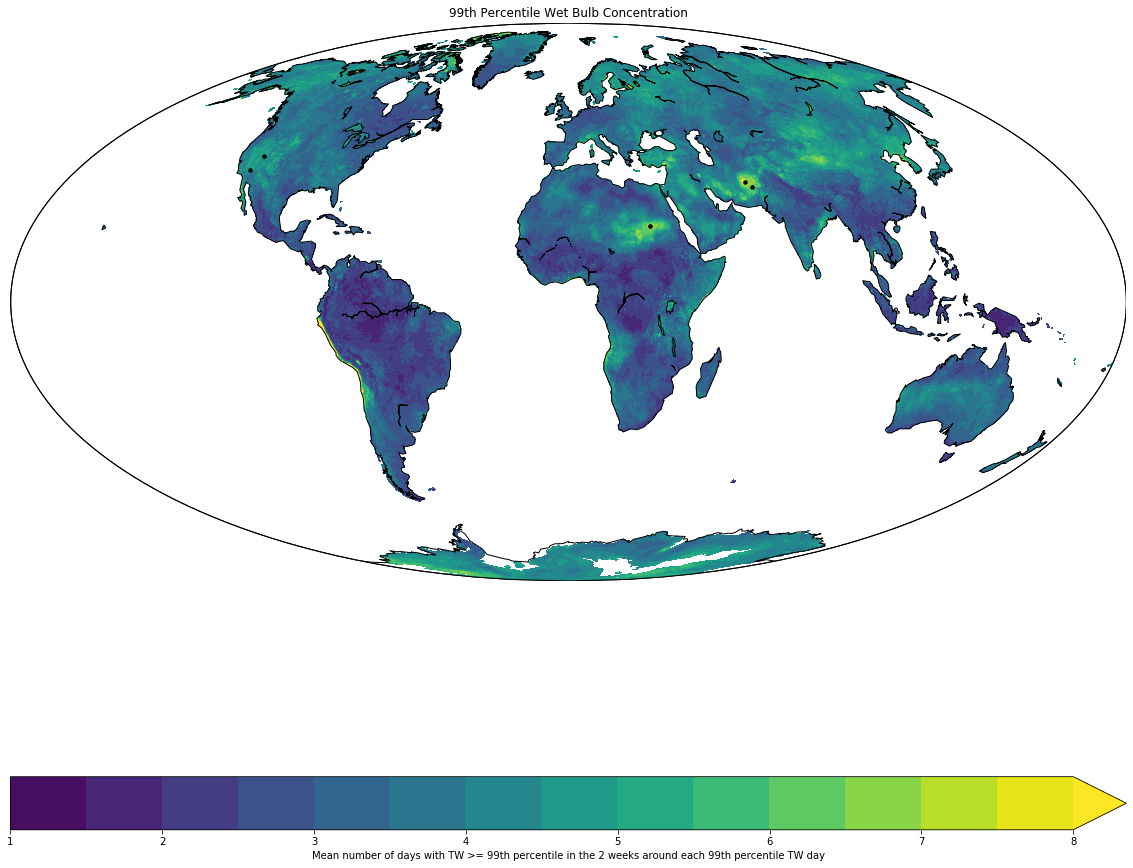

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


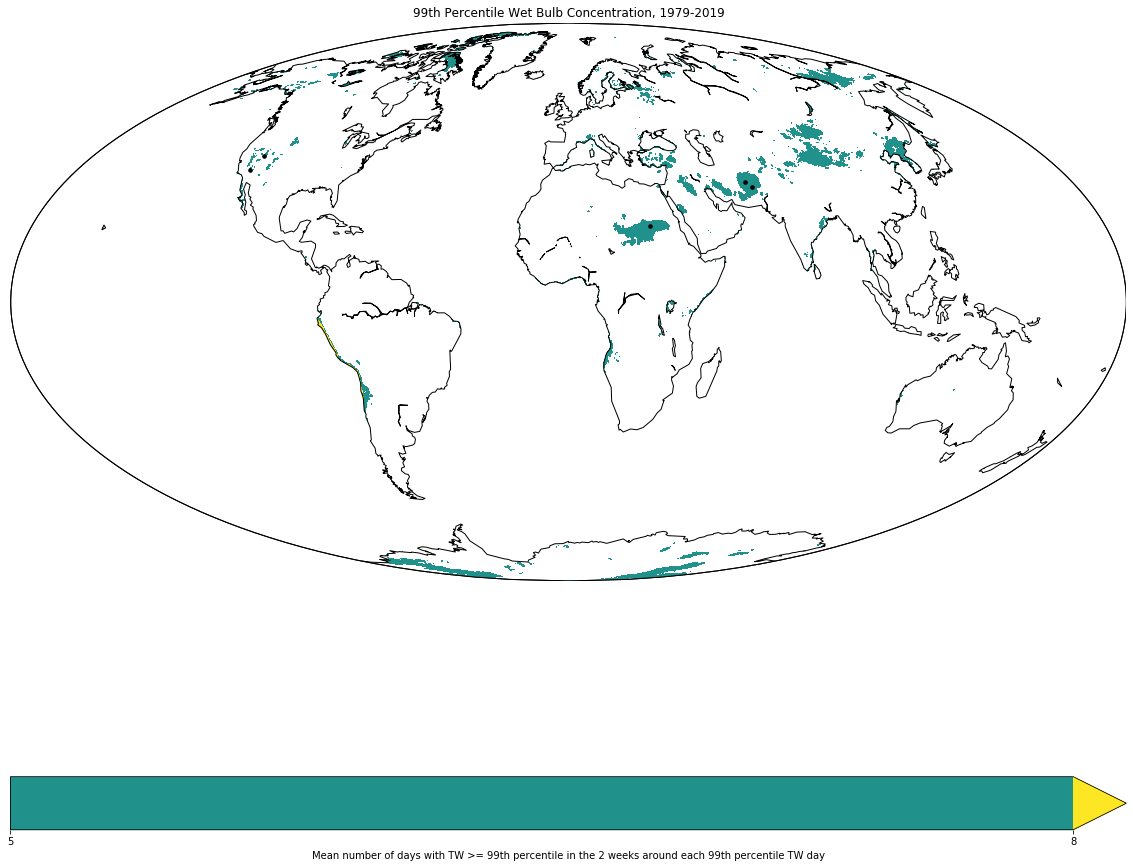

In [20]:
# map the locations tested for Afghanistan, the Sahara, and North America
# plot
plt.figure(figsize = (20,24))
map_num_surrounding_land = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_num_surrounding_land.drawcoastlines()
map_num_surrounding_land.drawmapboundary()
m_num_surrounding_land = map_num_surrounding_land.contourf(lons_2d, lats_2d, mean_num_surrounding_99_perc_days_xar_land_mask, 
                                                 np.linspace(1, 8, 15), extend = 'max', latlon = True)
cbar_num_surrounding_land = plt.colorbar(m_num_surrounding_land, orientation = 'horizontal')
cbar_num_surrounding_land.set_label('Mean number of days with TW >= 99th percentile in the 2 weeks around each 99th percentile TW day')
all_lats = [afgh_lat, afgh_lat_2, sah_lat, nam_lat, nam_lat_2]
all_lons = [afgh_lon, afgh_lon_2, sah_lon, nam_lon, nam_lon_2]
m_locs = map_num_surrounding_land.scatter(all_lons, all_lats, 50, 'k', '.', latlon = True)
plt.title('99th Percentile Wet Bulb Concentration')
plt.show()

plt.figure(figsize = (20,24))
map_num_surrounding_land = Basemap(projection = 'moll', resolution = 'c', lat_0 = 0, lon_0 = 0)
map_num_surrounding_land.drawcoastlines()
map_num_surrounding_land.drawmapboundary()
m_num_surrounding_land = map_num_surrounding_land.contourf(lons_2d, lats_2d, mean_num_surrounding_99_perc_days_xar_land_mask, 
                                                           np.linspace(5, 8, 2), extend = 'max', latlon = True)
cbar_num_surrounding_land = plt.colorbar(m_num_surrounding_land, orientation = 'horizontal')
cbar_num_surrounding_land.set_label('Mean number of days with TW >= 99th percentile in the 2 weeks around each 99th percentile TW day')
m_locs = map_num_surrounding_land.scatter(all_lons, all_lats, 50, 'k', '.', latlon = True)
plt.title('99th Percentile Wet Bulb Concentration, 1979-2019')
plt.show()

In [21]:
# function to have consistent y axis scales between the two plots for each place
# function to obtain and plot the TW and precipitation data for (input_lat, input_lon) in the given year. y_max sets
# the maximum y value of the summer only plot, if not 0 (if 0, uses default). plots on input fig and axs at the
# given loc_axs_row row and loc_axs_col column
def plot_TW_and_precip_set_y(input_lat, input_lon, year, y_max, fig, axs, loc_axs_row, loc_axs_col):
    # load TW data
    TW_data = nc.Dataset('/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % year)
    TWs = TW_data.variables['TW'][:]
    
    # load precip data
    precip_data = nc.Dataset('/dx01/data/ERA5/precip_dailytotal/precip_dailytotal_%s.nc' % year)
    precip = precip_data.variables['tp'][:]
    
    # get number of days in the year
    num_days = 365 
    if (year % 4 == 0):
        num_days = 366
    
    # select just this location's data
    TWs_curr = TWs[:, np.where(lons == input_lon), np.where(lats == input_lat)].reshape(num_days)
    precip_curr = precip[:, np.where(lats == input_lat), np.where(lons == input_lon)].reshape(num_days)

    # get the 99th percentile TW value in this location
    TW_99_curr = nearby_99_perc_days_2_week_window_summarized_wpercs[(nearby_99_perc_days_2_week_window_summarized_wpercs['latitude'] == input_lat) & 
                                                                (nearby_99_perc_days_2_week_window_summarized_wpercs['longitude'] == input_lon)]
    TW_99_curr = TW_99_curr.reset_index()['TW_99_percentile'][0]
    
    # overlay the plots
    axs[loc_axs_row, loc_axs_col].plot(TWs_curr[(num_days - 214):(num_days - 114)])
    axs[loc_axs_row, loc_axs_col].plot(np.repeat(TW_99_curr, 100))
    axs[loc_axs_row, loc_axs_col].set_title('%s°N, %s°E in %s' % (input_lat, input_lon, year))
    axs[loc_axs_row, loc_axs_col].tick_params(axis = 'y', colors = 'tab:blue')
    ax2 = axs[loc_axs_row, loc_axs_col].twinx()
    ax2.plot(precip_curr[(num_days - 214):(num_days - 114)]*1000, 'g')
    ax2.tick_params(axis = 'y', colors = 'darkgreen')
    # set the maximum y value of the precipitation scale for the summer plot
    if (y_max != 0):
        ax2.set_ylim([-(y_max) / 90, y_max])
    # only set the left axis title if it is the left plot, also remove right y labels
    if (loc_axs_col == 0):
#         axs[loc_axs_row, loc_axs_col].set_ylabel('Maximum wet bulb temperature, °C')
        ax2.set_yticklabels([])
#     # only set the right axis title if it is the right plot
#     if (loc_axs_col == 1):
#         ax2.set_ylabel('Precipitation, mm')
#     # only set the x axis label if it is the bottom row
#     if (loc_axs_row == 2):
#         axs[loc_axs_row, loc_axs_col].set_xlabel('Day since June 1st')

Text(0.965, 0.5, 'Precipitation, mm')

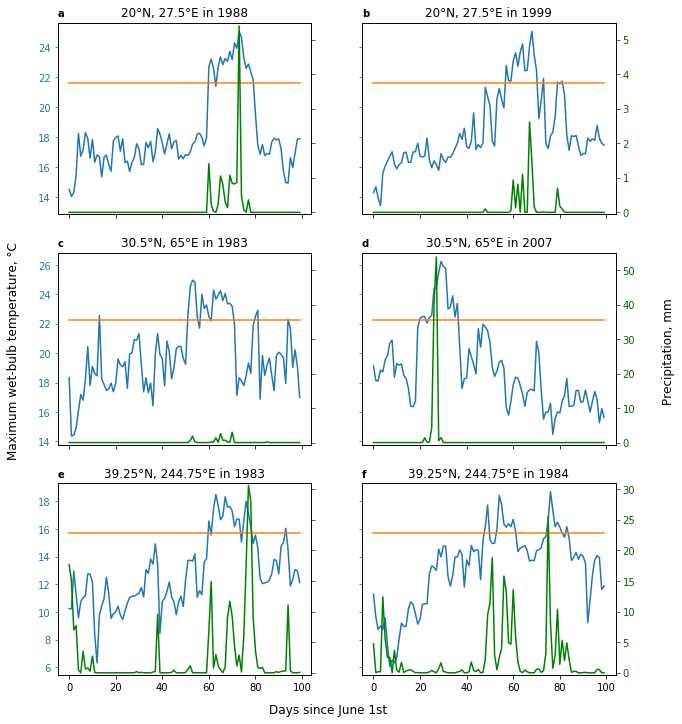

In [22]:
# get latitude and longitude values from one file that is in the set for all the years
curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_2000_0UTC.nc'
# load the data for this year
curr_data = nc.Dataset(curr_filename)
lat_info = curr_data.variables['latitude']
lats = lat_info[:]
lon_info = curr_data.variables['longitude']
lons = lon_info[:]

fig, axs = plt.subplots(3, 2, figsize = [10, 12], sharex = 'all', sharey = 'row')
plot_TW_and_precip_set_y(sah_lat, sah_lon, sah_year_1, 5.5, fig, axs, 0, 0)
plot_TW_and_precip_set_y(sah_lat, sah_lon, sah_year_2, 5.5, fig, axs, 0, 1)
plot_TW_and_precip_set_y(afgh_lat_2, afgh_lon_2, afgh_2_year_1, 55, fig, axs, 1, 0)
plot_TW_and_precip_set_y(afgh_lat_2, afgh_lon_2, afgh_2_year_2, 55, fig, axs, 1, 1)
# plot_TW_and_precip_set_y(nam_lat, nam_lon, nam_year_1, 36, fig, axs, 2, 0)
# plot_TW_and_precip_set_y(nam_lat, nam_lon, nam_year_2, 36, fig, axs, 2, 1)
plot_TW_and_precip_set_y(nam_lat_2, nam_lon_2, nam_2_year_1, 31, fig, axs, 2, 0)
plot_TW_and_precip_set_y(nam_lat_2, nam_lon_2, nam_2_year_2, 31, fig, axs, 2, 1)
axs[0, 0].set_title('a', loc = 'left', fontsize = 'medium', fontweight = 'bold')
axs[0, 1].set_title('b', loc = 'left', fontsize = 'medium', fontweight = 'bold')
axs[1, 0].set_title('c', loc = 'left', fontsize = 'medium', fontweight = 'bold')
axs[1, 1].set_title('d', loc = 'left', fontsize = 'medium', fontweight = 'bold')
axs[2, 0].set_title('e', loc = 'left', fontsize = 'medium', fontweight = 'bold')
axs[2, 1].set_title('f', loc = 'left', fontsize = 'medium', fontweight = 'bold')
# fig.suptitle('Daily Maximum Wet-Bulb Temperature and Total Precipitation', fontsize = 'x-large', y = 0.93)
fig.text(0.5, 0.08, 'Days since June 1st', ha = 'center', fontsize = 'large')
fig.text(0.055, 0.5, 'Maximum wet-bulb temperature, °C', rotation = 'vertical', va = 'center', fontsize = 'large')
fig.text(0.965, 0.5, 'Precipitation, mm', rotation = 'vertical', va = 'center', fontsize = 'large')

# Trends in global mean wet-bulb temperature and global mean 99th percentile wet-bulb temperature

These calculations are done to obtain values referenced (for comparison to the other trends) in the paper.

In [23]:
# code to loop over all the years and calculate the global mean TW and global mean of 99th percentile TW
percentile_val = 99

# will store the results
percentile_results_global_mean = []
global_mean_results = []

# loop through the year numbers to calculate the percentile value for each year, 
# adding the results for each year to a list of arrays
yr_nums = np.linspace(1979, 2019, 41, dtype = int)
for yr in yr_nums:
    curr_filename = '/dx01/data/ERA5/humid_heat/TW_daily_max_ERA5_historical_an-sfc_%s_0UTC.nc' % yr
    # load the data for this year
    curr_data = nc.Dataset(curr_filename)
    time_info = curr_data.variables['time']
    times = time_info[:]
    lat_info = curr_data.variables['latitude']
    lats = lat_info[:]
    lon_info = curr_data.variables['longitude']
    lons = lon_info[:]
    TW_info = curr_data.variables['TW']
    TWs = TW_info[:]

    # calculate the value at the percentile of interest for the year at each grid box
    curr_percentile_vals = np.percentile(TWs, percentile_val, axis = 0)

    # include mask for NA locations
    curr_percentile_vals_mask = np.where(np.isnan(curr_percentile_vals), True, False)
    curr_percentile_vals = np.ma.array(curr_percentile_vals, mask = curr_percentile_vals_mask)

    # calculate the weighted mean of these percentile values across the world
    curr_mean_percentile_vals = np.ma.average(curr_percentile_vals, 
                                              weights = np.broadcast_to(np.cos(np.deg2rad(lats)), 
                                                                        curr_percentile_vals.shape))
    # calculate the weighted mean of the daily max TW values across the world
    curr_mean = np.ma.average(TWs, weights = np.broadcast_to(np.cos(np.deg2rad(lats)), TWs.shape))

    # add to arrays
    percentile_results_global_mean.append(curr_mean_percentile_vals)
    global_mean_results.append(curr_mean)


In [24]:
# calculate trends
print(percentile_results_global_mean)
print(global_mean_results)
print()

# first for global mean 99th percentile
model_perc_global_mean = sm.OLS(percentile_results_global_mean, sm.add_constant(np.linspace(0, 40, 41))).fit()
print([model_perc_global_mean.params[1], model_perc_global_mean.rsquared, model_perc_global_mean.pvalues[1]])
# calculate the change over the 41 years
print(model_perc_global_mean.params[1]*40)
print()

# now for global mean
model_global_mean = sm.OLS(global_mean_results, sm.add_constant(np.linspace(0, 40, 41))).fit()
print([model_global_mean.params[1], model_global_mean.rsquared, model_global_mean.pvalues[1]])
# calculate the change over the 41 years
print(model_global_mean.params[1]*40)

[18.909664561663476, 18.918548184353554, 18.84595786457391, 18.85260309296935, 19.082169596448086, 18.86665589493593, 18.6973312692219, 18.800678526772824, 19.037285423761016, 19.05819477374995, 18.915097010843404, 19.04333919977382, 19.11648997377466, 18.819139258970175, 18.922072060318364, 18.920716233426337, 19.015641482525435, 18.912129054409945, 19.104781842079102, 19.362042512090643, 18.976328201184476, 18.881471471085, 19.08586353417022, 19.14563172417161, 19.145533677427775, 19.04802255300412, 19.16935716636404, 19.127869207801254, 19.05622473642131, 18.945291695023506, 19.061005464970673, 19.367515497863053, 19.061180288704552, 19.14066233742202, 19.193599723856476, 19.17303024378148, 19.275719242441188, 19.482869746427554, 19.31703256870509, 19.24377819694371, 19.432796036202824]
[12.487327, 12.576617, 12.614762, 12.442367, 12.600382, 12.4029455, 12.37832, 12.466486, 12.569779, 12.606766, 12.514373, 12.711828, 12.669717, 12.444108, 12.485433, 12.502379, 12.653073, 12.54529, 1